Authors: Cynarski Michał & Barszczak Barłomiej
AGH WEAIiIB AIR-ISZ

# Bayesian models for predicting the number of fatalities in terrorist attacks using GTD data.

### Libraries import

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from dags import plot_poisson_dag, plot_negative_binomial_dag
from functions import *
import xarray as xr


# SEED = 19052025
SEED = 123

MODEL_PATH_1 = "code_1.stan"
MODEL_PATH_1_PPC = "code_1_pcc.stan"

MODEL_PATH_2 = "code_2.stan"
MODEL_PATH_2_PPC = "code_2_ppc.stan"

### 1. Problem formulation

What does a terrorist attack depend on and how many victims can it claim?
This was the clue and starting point of our project.
Instead of focusing on terrorism as social or political aspect, we focused on pure analyze of the attacks' data.
To be more precise, we tried to predict the number of victims based on specific characteristics of an incident.

However, the number of victims of the attack cannot be simply predicted.
There are some obviousness that, for example, bomb can kill more people than knife, but this is a rather more complex problem that we have taken upon our honor to investigate.

Need to write more. IDK now what.


### 2. Data Preprocessing

The data we used in our project is from Global Terrorism Database (GTB).
It is opensource database created by researchers at University of Maryland, who obtained a large database originally collected by the Pinkerton Global Intelligence Services.
Database contains records of almost all terrorism attacks from years 1970 to 2017 except year 1993.
Records from 1993 are missing because of PGIS office move (error during file migration process), and these data have never been fully recovered.
Database contains 135 columns in total, which describe attack, for example weapon type, date of attack, country, target and many more.

In [2]:
# df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding='latin-1', low_memory=False)
df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding='latin-1')
df.head()

/tmp/ipykernel_1082/2997657929.py:2: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding='latin-1')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


Not all records have fulfilled all variables, but the most wanted columns like country or number of attackers was filled.
Because of that, the database needs to be preprocessed. The preprocessing takes several steps.
First step was to take the columns that we proposed and have the biggest impact in number of victims, and drop the records where were missing values.
Next step was filter out the records where the nperps column is positive. Some records contain information that number of attackers is -99.
This does not mean that -99 attackers took place in attack, but the value is missing.
A further step was to take random sample of 200 records from cleared dataframe.

In [3]:
selected_columns = ['nkill', 'attacktype1', 'weaptype1', 'targtype1', 'country', 'nperps']
df = df[selected_columns].dropna()  # Filter out rows where 'nkill' is zero or negative
print(len(df), "rows in the dataset before filtering")

df = df[df['nperps'] > 0]  # Filter out rows where 'nperps' is zero or negative
print(len(df), "rows in the dataset after filtering nperps > 0")

df = df.sample(n=200, random_state=SEED)
df.to_csv('data.csv')
print(len(df), "rows in the dataset after filtering")
df.head()

106122 rows in the dataset before filtering
27348 rows in the dataset after filtering nperps > 0
200 rows in the dataset after filtering


,nkill,attacktype1,weaptype1,targtype1,country,nperps
9746,35.0,2,5,1,61,100.0
168131,3.0,2,9,3,138,3.0
174923,5.0,2,5,3,4,1.0
125972,7.0,3,6,14,110,1.0
156463,0.0,2,5,22,19,7.0


The last step was to create new dataframe without nkill column, and normalize it.
Normalization was performed by subtracting the mean and dividing by the standard deviation.

In [4]:
X = df[['attacktype1', 'weaptype1', 'targtype1', 'nperps', 'country']]

X_norm = (X - X.mean()) / X.std()

N_incidents = len(df)
print("Number of incidents:", N_incidents)


data_sim_ppc = {
    'N': N_incidents,
    'K': len(X_norm.columns),
    'X': X_norm,
    'nkill': df['nkill'].astype(int),
}


data_sim_prod = {
    'N': N_incidents,
    'K': len(X_norm.columns),
    'X': X_norm,
    'nkill': df['nkill'].astype(int)
}


X_norm

Number of incidents: 200


,attacktype1,weaptype1,targtype1,nperps,country
9746,-0.554791,-0.639187,-0.972199,0.052526,-0.890764
168131,-0.554791,1.772838,-0.649477,-0.084676,0.083232
174923,-0.554791,-0.639187,-0.649477,-0.087505,-1.611774
125972,0.029200,-0.036180,1.125492,-0.087505,-0.270948
156463,-0.554791,-0.639187,2.416379,-0.079018,-1.422034
...,...,...,...,...,...
34912,-0.554791,-0.639187,-0.972199,-0.081847,0.348868
148531,3.533145,4.184863,-0.488117,-0.083262,-0.460688
16407,0.029200,-0.036180,-0.488117,-0.087505,0.298270
142729,-0.554791,-0.639187,-0.004034,-0.087505,-1.611774


### 3. Model

Before discussing model creation, we decided to analyze once more and visualize the data.

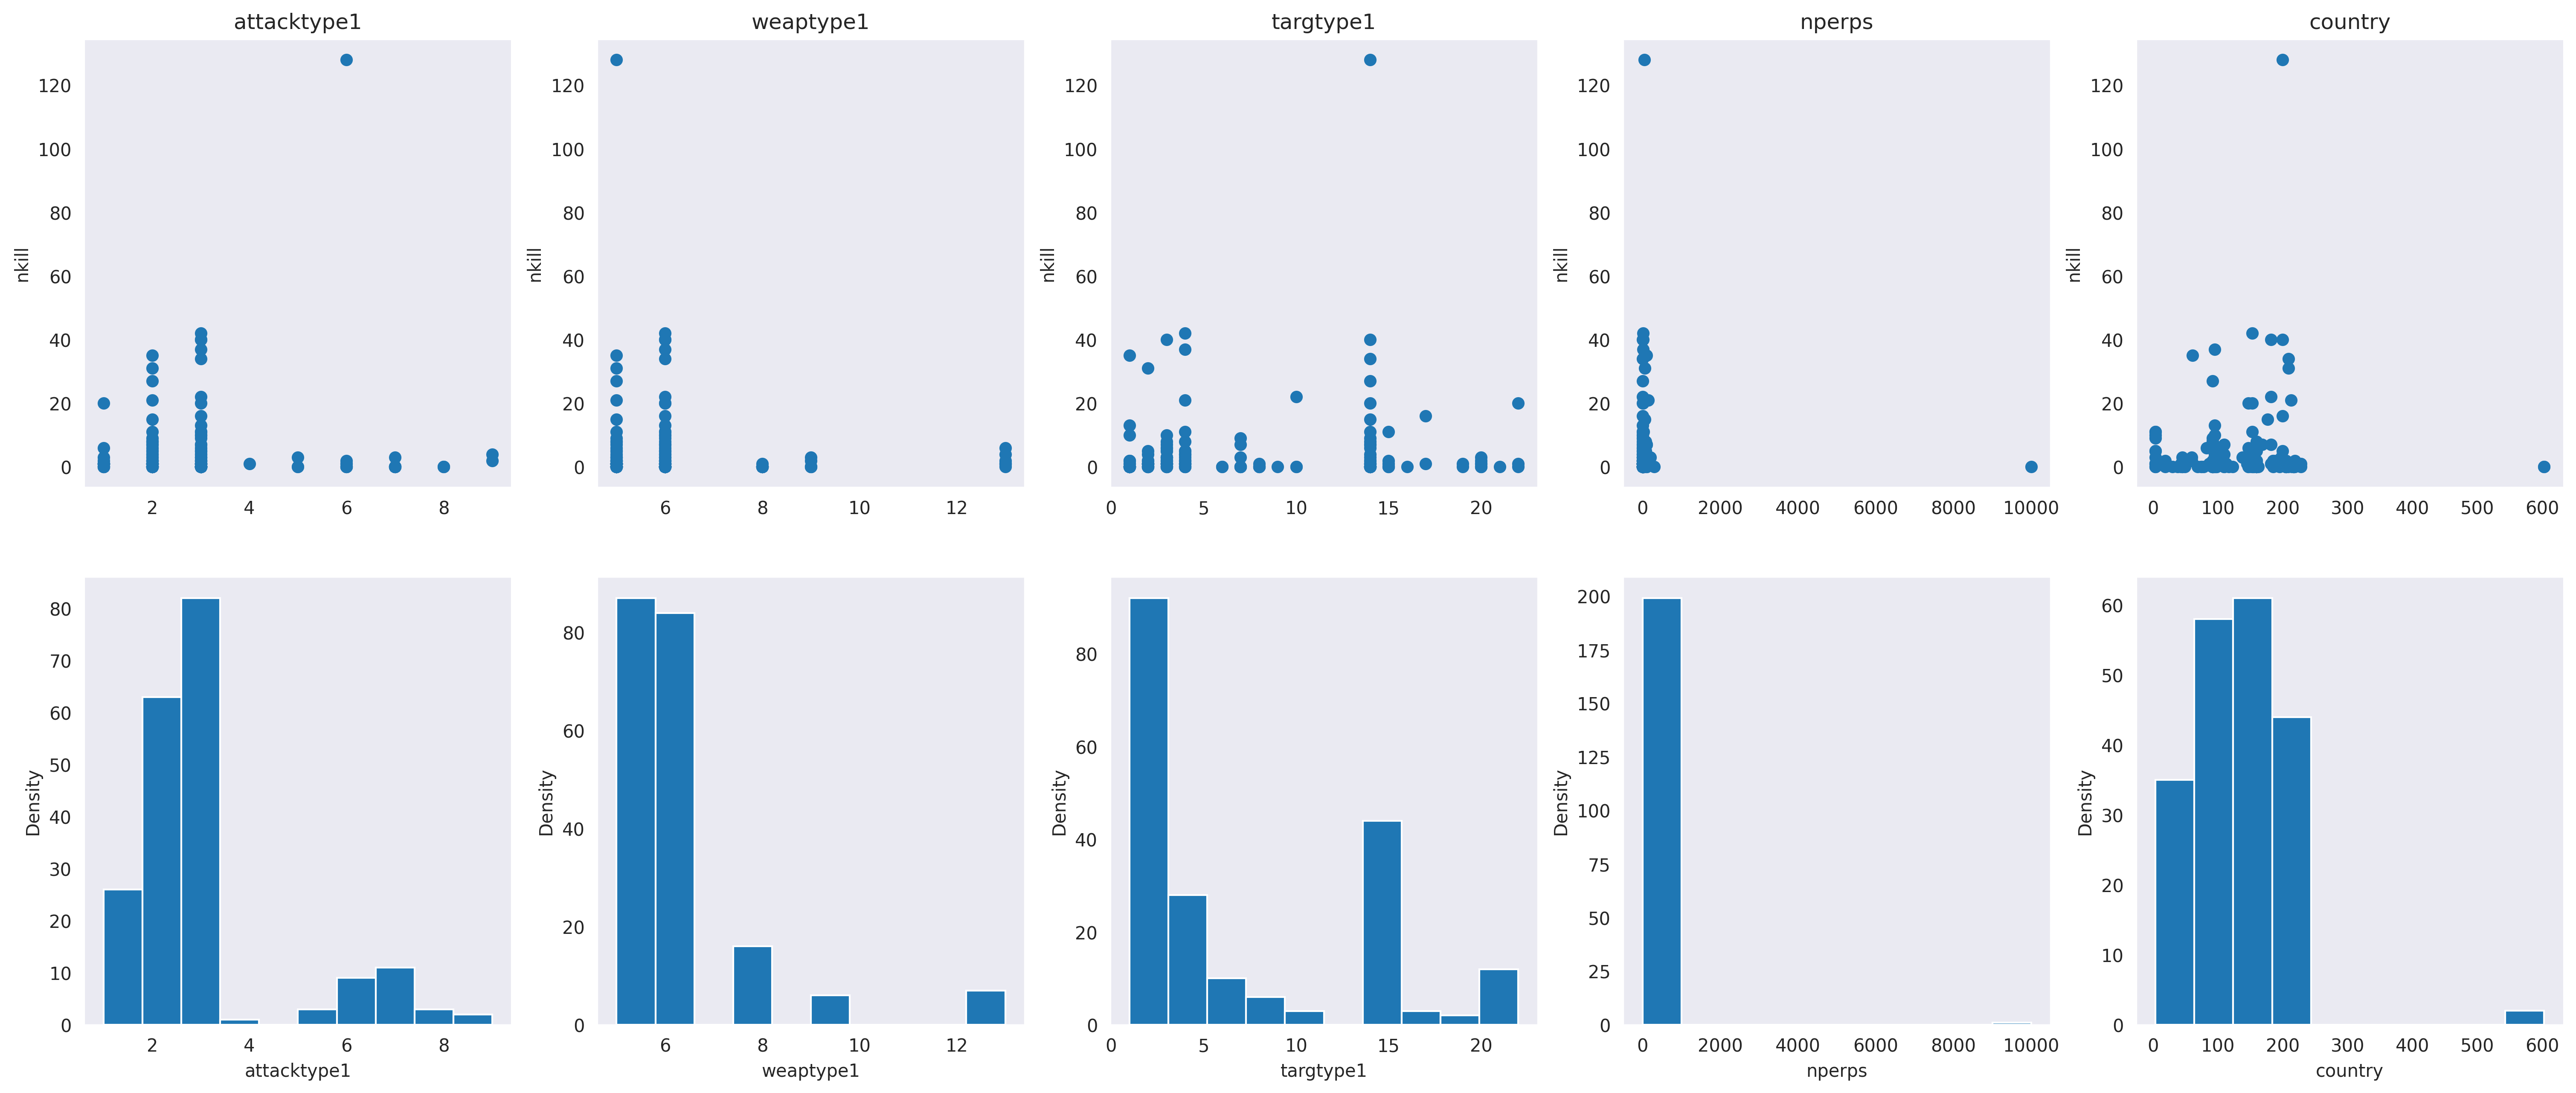

In [5]:
scatter_hist_display(X, df["nkill"])

The above plots presents that there is no clear linear relationship between number of victims and the other features.
This could be due to categorical variables.
The data visualized at the charts shows that most of the attacks took place using bombing/explosions or with guns.
Also, these kinds of attacks have the most impact in the number of victims in single attack.
What's more in most of the attacks involved less than 250 attackers.

Based on these observations, we decided to use more complex model, which is more suitable for this problem than linear models.

The first model is Poisson regression model with log link function.
The log link function is a linear combination of parameter Alpha and set X multiplied by corresponding factor Beta.
The parameters Alpha and Beta are get from normal distribution with mean 2.5 combined with standard deviation of 0.75 and mean 0 with standard deviation of 0.25 respectively.
This model uses all the predictors.

Second model is similar to the first model. Second model uses a negative binomial likelihood instead of Poisson distribution.
Furthermore, this model gains additional parameter named Phi, which is drawn from exponential distribution with beta set on 0.5.
Alpha and Beta parameters also have changed. Now mean is set to 1.5 with the same standard deviation for Alpha, and same mean with standard deviation set to 0.5 for Beta.
Likewise to first model, this also uses all the predictors.

In [6]:
data_sim_prod

{'N': 200,
 'K': 5,
 'X':         attacktype1  weaptype1  targtype1    nperps   country
 9746      -0.554791  -0.639187  -0.972199  0.052526 -0.890764
 168131    -0.554791   1.772838  -0.649477 -0.084676  0.083232
 174923    -0.554791  -0.639187  -0.649477 -0.087505 -1.611774
 125972     0.029200  -0.036180   1.125492 -0.087505 -0.270948
 156463    -0.554791  -0.639187   2.416379 -0.079018 -1.422034
 ...             ...        ...        ...       ...       ...
 34912     -0.554791  -0.639187  -0.972199 -0.081847  0.348868
 148531     3.533145   4.184863  -0.488117 -0.083262 -0.460688
 16407      0.029200  -0.036180  -0.488117 -0.087505  0.298270
 142729    -0.554791  -0.639187  -0.004034 -0.087505 -1.611774
 166239    -0.554791  -0.639187  -0.649477 -0.086091 -1.422034
 
 [200 rows x 5 columns],
 'nkill': 9746      35
 168131     3
 174923     5
 125972     7
 156463     0
           ..
 34912      0
 148531     4
 16407      1
 142729     0
 166239     2
 Name: nkill, Length: 200, dt

### 4. Priors

The selected priors for the models are the parameters Alpha, Beta and a prior for the standard deviation Phi.
For Alpha, Beta, a normal distribution was selected as the prior because we do not have any expertise knowledge suggesting the use of a better more specialized distribution.
For the Phi parameter, we selected an exponential distribution because it is often used with negative binomial models.

For these models we selected specific values based on our knowledge and have strong impact on each predictor on the outcome.

#### Model 1

In [7]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_1_PPC)

sim1 = model1_ppc.sample(data=data_sim_ppc,
                        seed=SEED)

df_1_ppc = sim1.draws_pd()

18:54:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:46 - cmdstanpy - INFO - CmdStan done processing.


In [8]:
df_1_ppc

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_sim[191],nkill_sim[192],nkill_sim[193],nkill_sim[194],nkill_sim[195],nkill_sim[196],nkill_sim[197],nkill_sim[198],nkill_sim[199],nkill_sim[200]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,2.0,1.0,3.0,3.0,1.0,0.0,3.0,2.0,2.0,1.0
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,6.0,16.0,11.0,4.0,13.0,5.0,7.0,6.0,7.0
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,7.0,10.0,10.0,6.0,2.0,15.0,4.0,10.0,7.0,14.0
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,2.0,2.0,10.0,2.0,1.0,4.0,23.0,6.0,3.0,1.0
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,2.0,0.0,2.0,0.0,9.0,1.0,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,26.0,59.0,43.0,36.0,6.0,49.0,292.0,48.0,14.0,29.0
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,34.0,25.0,21.0,10.0,16.0,25.0,59.0,23.0,12.0,9.0
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,8.0,5.0,3.0,2.0,7.0,8.0,3.0,6.0,11.0,7.0
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,6.0,11.0,3.0,8.0,10.0,0.0,6.0,5.0,4.0


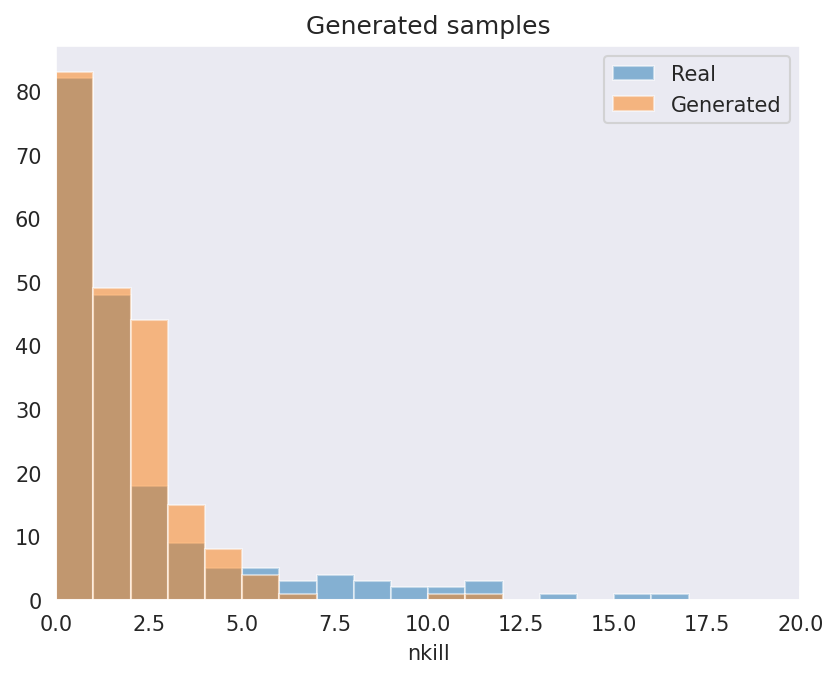

In [9]:
hist_compare(df['nkill'], df_1_ppc.iloc[0][8:])

As we can see on the chart, generated values matches with real data.
This leads to conclusion, that the samples generated from the prior in model are good, and makes sense.
The distribution of the generated samples overlaps with the actual data, however the samples for nkill equal to 0 are overestimated.

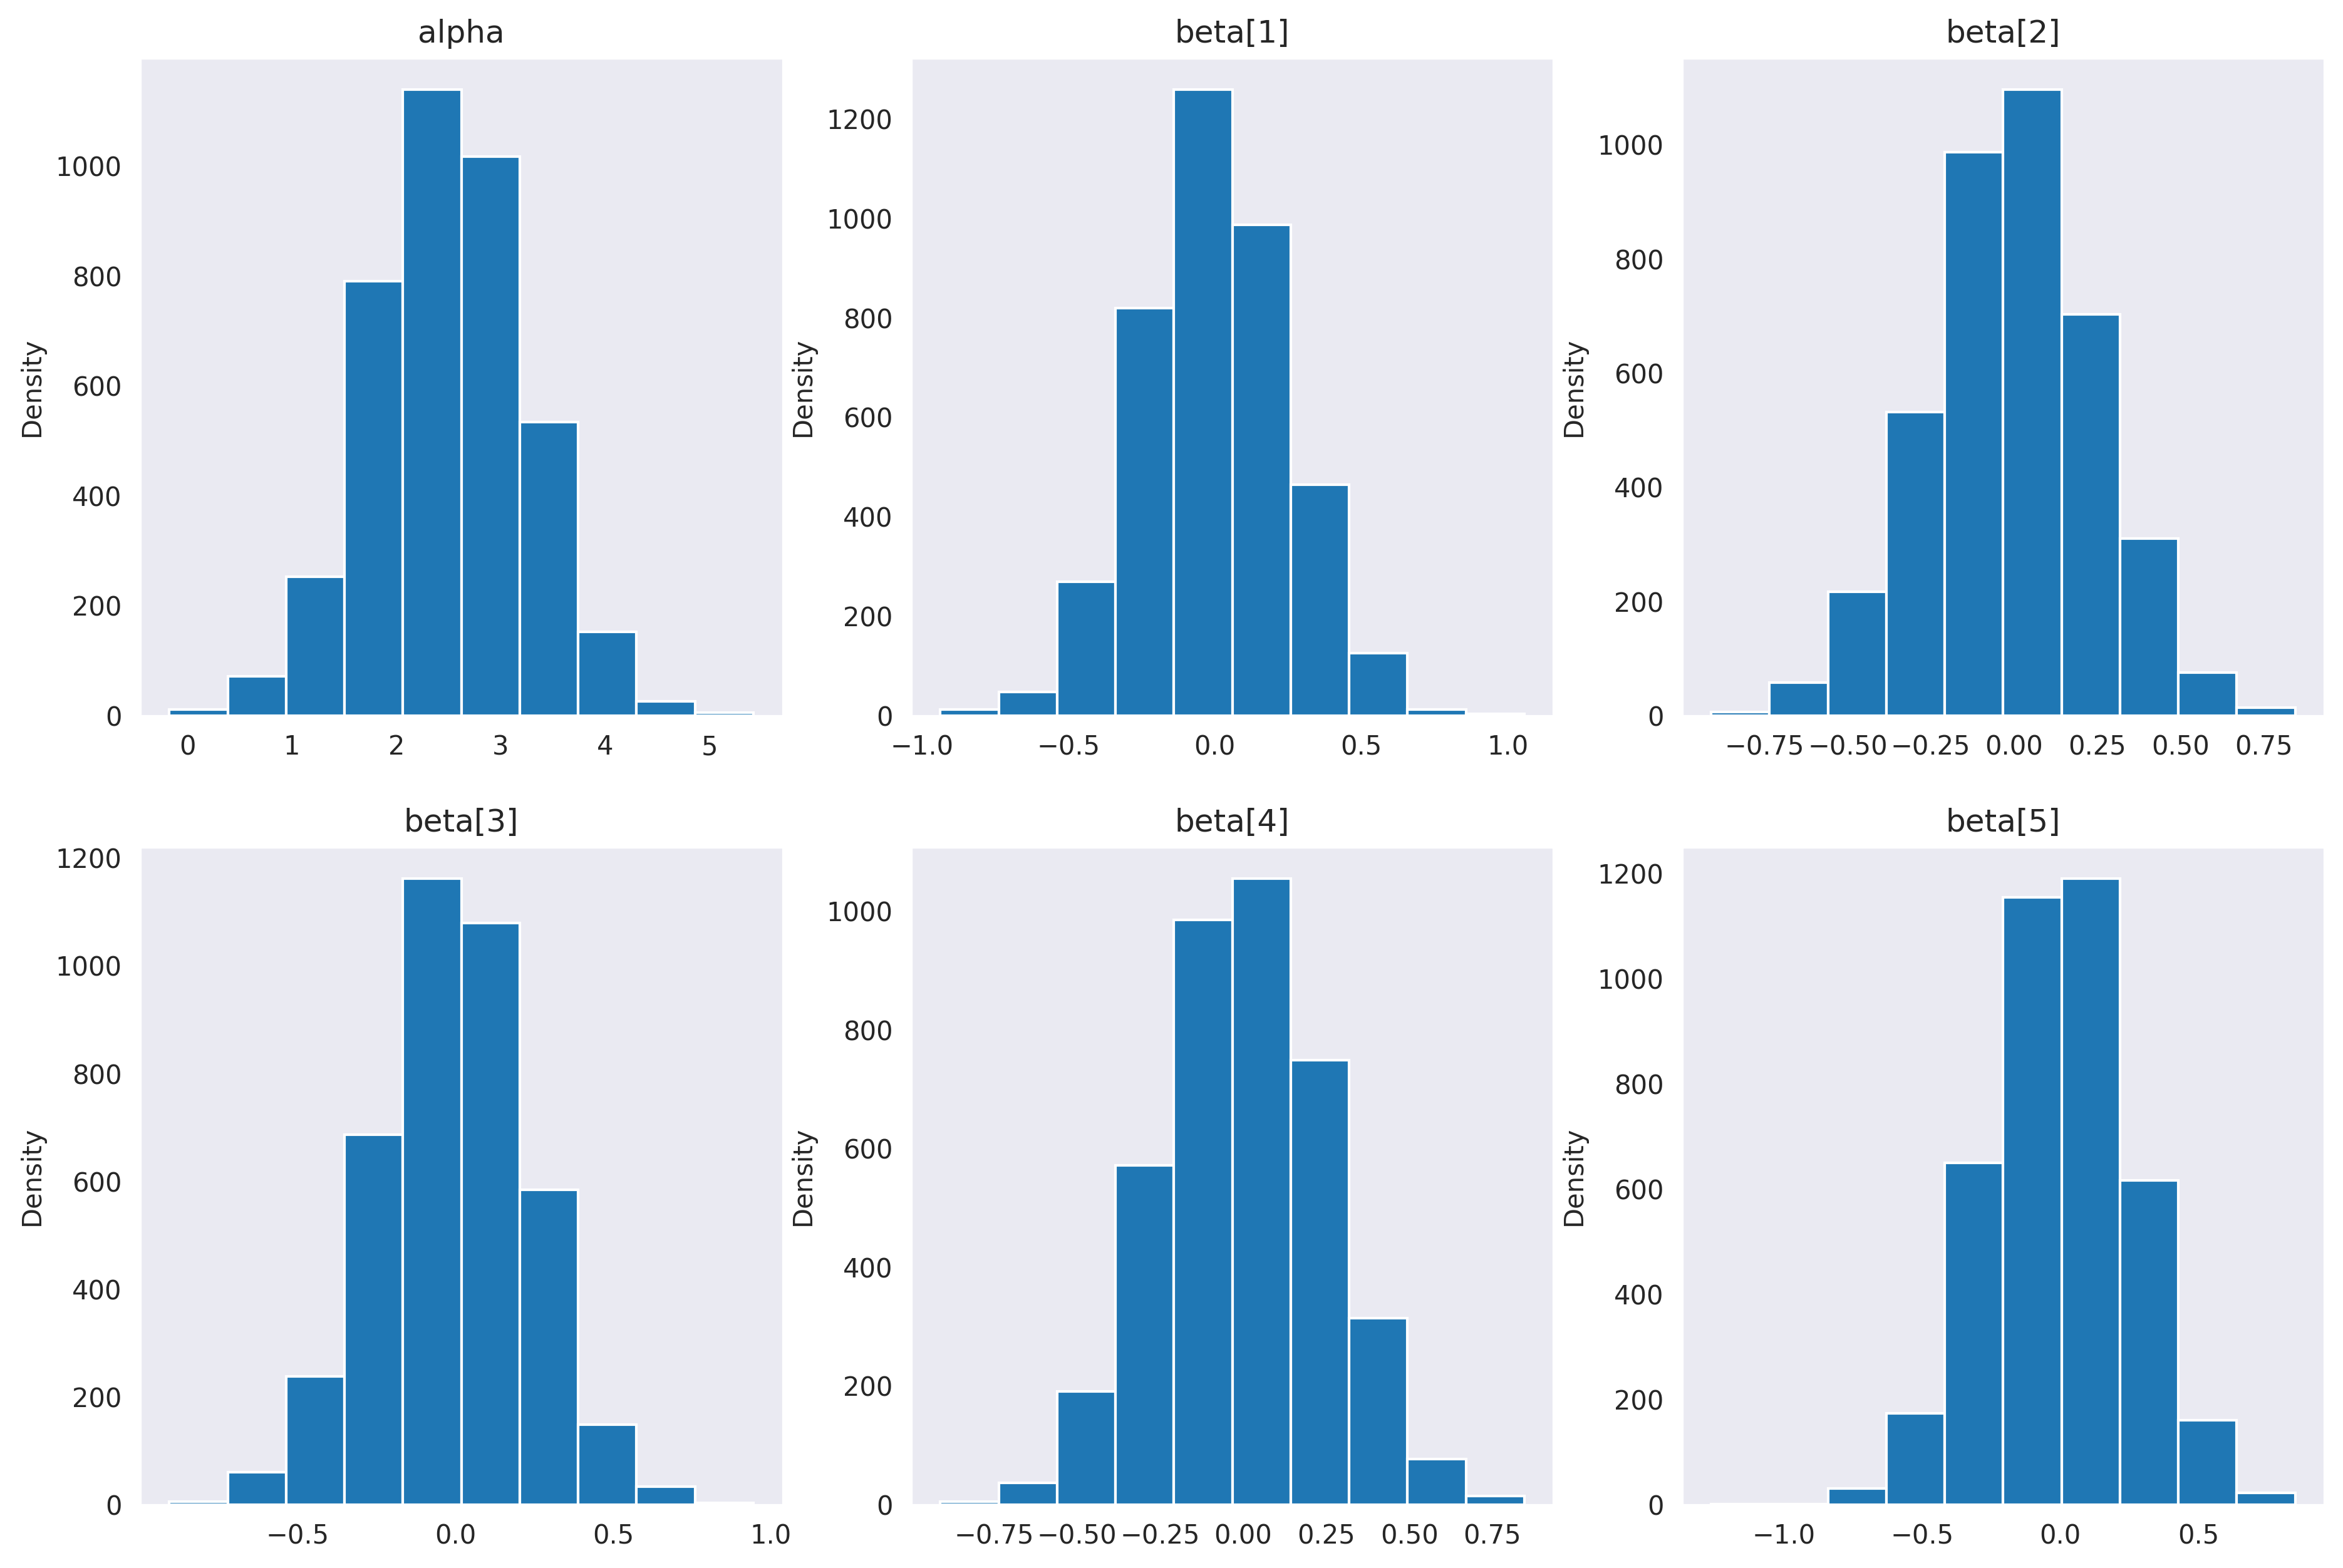

In [10]:
fig, axs = plt.subplots(2, 3, dpi=300)
fig.set_size_inches(15, 10)

for i, col in enumerate(["alpha", 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]']):
    axs[i//3, i%3].hist(df_1_ppc[col])
    axs[i//3, i%3].set_ylabel("Density")
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].grid()

Histograms also confirm, that the prior distribution comply with the initial assumptions.

In [11]:
df_1_ppc

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_sim[191],nkill_sim[192],nkill_sim[193],nkill_sim[194],nkill_sim[195],nkill_sim[196],nkill_sim[197],nkill_sim[198],nkill_sim[199],nkill_sim[200]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,2.0,1.0,3.0,3.0,1.0,0.0,3.0,2.0,2.0,1.0
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,6.0,16.0,11.0,4.0,13.0,5.0,7.0,6.0,7.0
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,7.0,10.0,10.0,6.0,2.0,15.0,4.0,10.0,7.0,14.0
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,2.0,2.0,10.0,2.0,1.0,4.0,23.0,6.0,3.0,1.0
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,2.0,0.0,2.0,0.0,9.0,1.0,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,26.0,59.0,43.0,36.0,6.0,49.0,292.0,48.0,14.0,29.0
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,34.0,25.0,21.0,10.0,16.0,25.0,59.0,23.0,12.0,9.0
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,8.0,5.0,3.0,2.0,7.0,8.0,3.0,6.0,11.0,7.0
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,6.0,11.0,3.0,8.0,10.0,0.0,6.0,5.0,4.0


Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200


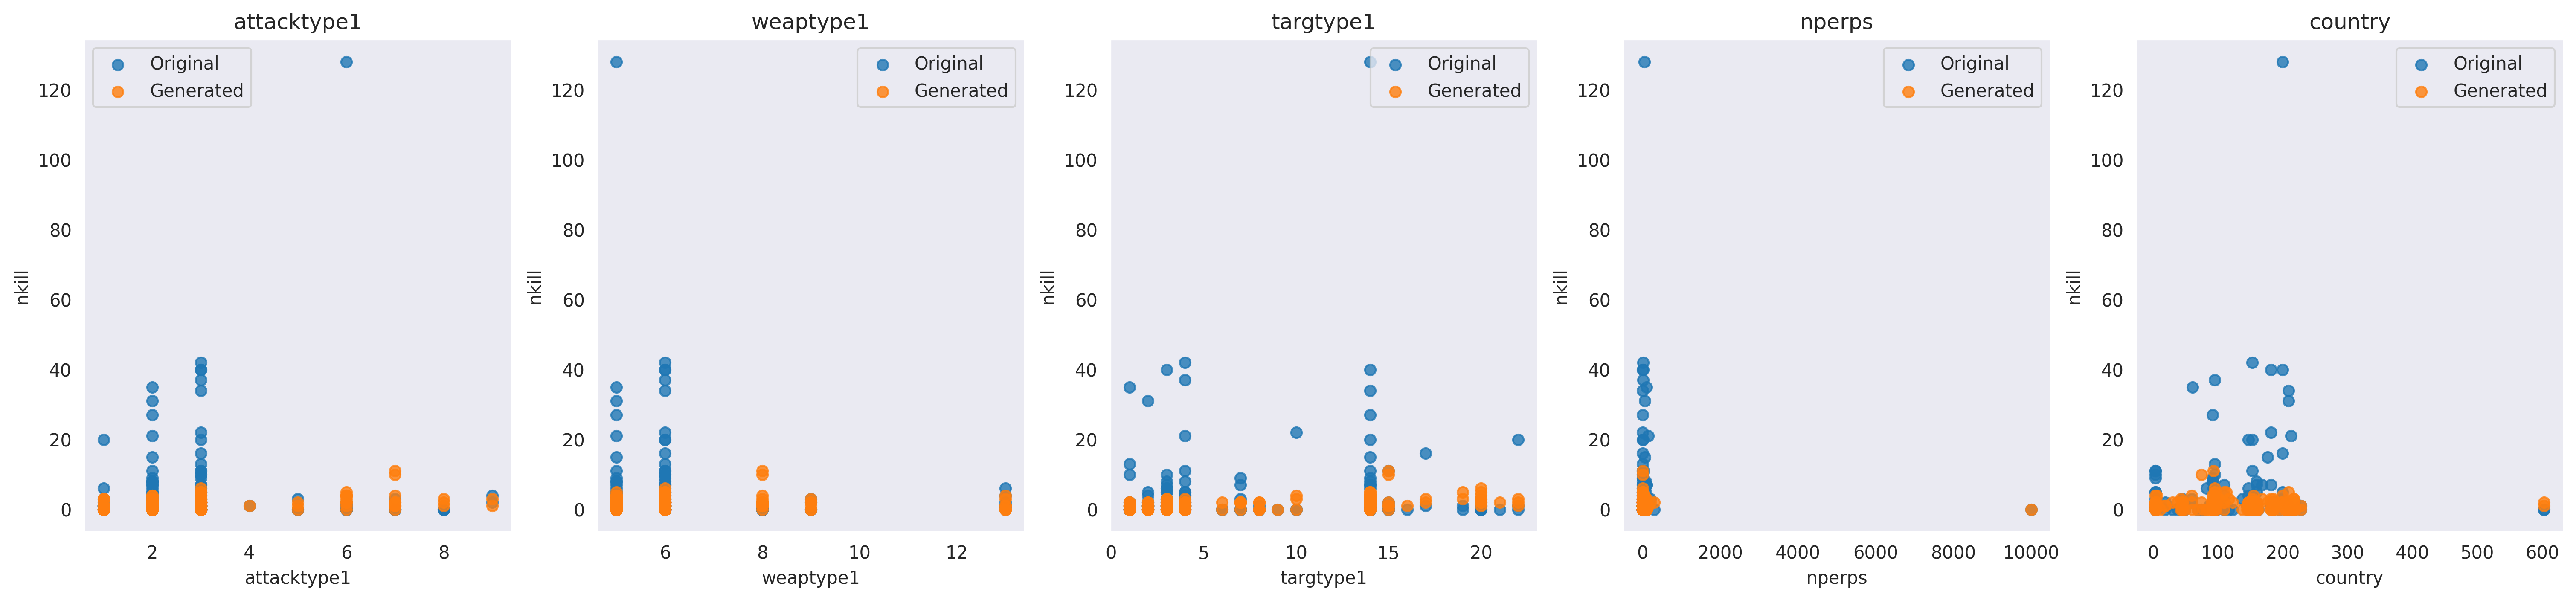

In [12]:
scatter_compare_display(X, df["nkill"], df_1_ppc.iloc[0][16:])

Once again, generated samples from the prior make sense and align with the initial assumptions.

In [13]:
df_1_ppc

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_sim[191],nkill_sim[192],nkill_sim[193],nkill_sim[194],nkill_sim[195],nkill_sim[196],nkill_sim[197],nkill_sim[198],nkill_sim[199],nkill_sim[200]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,2.0,1.0,3.0,3.0,1.0,0.0,3.0,2.0,2.0,1.0
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,6.0,16.0,11.0,4.0,13.0,5.0,7.0,6.0,7.0
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,7.0,10.0,10.0,6.0,2.0,15.0,4.0,10.0,7.0,14.0
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,2.0,2.0,10.0,2.0,1.0,4.0,23.0,6.0,3.0,1.0
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,2.0,0.0,2.0,0.0,9.0,1.0,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,26.0,59.0,43.0,36.0,6.0,49.0,292.0,48.0,14.0,29.0
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,34.0,25.0,21.0,10.0,16.0,25.0,59.0,23.0,12.0,9.0
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,8.0,5.0,3.0,2.0,7.0,8.0,3.0,6.0,11.0,7.0
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,6.0,11.0,3.0,8.0,10.0,0.0,6.0,5.0,4.0


#### Model 2

In [14]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_2_PPC)

sim1 = model1_ppc.sample(data=data_sim_ppc,
                        seed=SEED) #123

df_2_ppc = sim1.draws_pd()

18:54:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:50 - cmdstanpy - INFO - CmdStan done processing.
18:54:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 1.50682e+10, but must be less than 1073741824.000000 (in 'code_2_ppc.stan', line 19, column 4 to column 85)
	Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 2.0104e+09, but must be less than 1073741824.000000 (in 'code_2_ppc.stan', line 19, column 4 to column 85)
	Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 5.68275e+10, but must be less than 1073741824.000000 (in 'code_2_ppc.stan', line 19, column 4 to column 85)
Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 2.0125e+10, but must be less than 1073741824.000000 (in 'code_2_ppc.stan', line 19, column 4 to column 85)
	Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 2.58556e+13, but

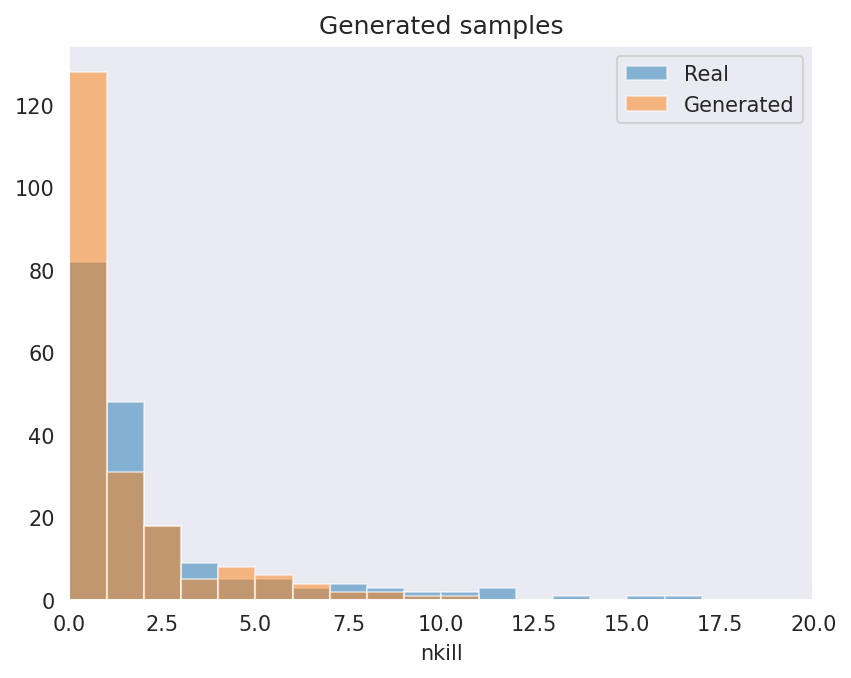

In [15]:
hist_compare(df['nkill'], df_2_ppc.iloc[0][8:])

As we can see on the chart, generated values matches with real data.
This leads to conclusion, that the samples generated from the prior in model are good, and makes sense.
The distribution of the generated samples overlaps with the actual data, however the samples for nkill equal to 0 are overestimated.

In [16]:
for n in range(0, 100):
    true_count = np.sum(df['nkill'] == n)
    pred_count = np.sum(np.round(df_2_ppc.iloc[0][8:]) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")

Number of victims = 0: Real = 82, Predicted = 128
Number of victims = 1: Real = 48, Predicted = 32
Number of victims = 2: Real = 18, Predicted = 17
Number of victims = 3: Real = 9, Predicted = 6
Number of victims = 4: Real = 5, Predicted = 8
Number of victims = 5: Real = 5, Predicted = 6
Number of victims = 6: Real = 3, Predicted = 4
Number of victims = 7: Real = 4, Predicted = 2
Number of victims = 8: Real = 3, Predicted = 2
Number of victims = 9: Real = 2, Predicted = 1
Number of victims = 10: Real = 2, Predicted = 1
Number of victims = 11: Real = 3, Predicted = 0
Number of victims = 13: Real = 1, Predicted = 0
Number of victims = 15: Real = 1, Predicted = 0
Number of victims = 16: Real = 1, Predicted = 0
Number of victims = 20: Real = 2, Predicted = 0
Number of victims = 21: Real = 1, Predicted = 0
Number of victims = 22: Real = 1, Predicted = 0
Number of victims = 27: Real = 1, Predicted = 0
Number of victims = 31: Real = 1, Predicted = 0
Number of victims = 34: Real = 1, Predicted

Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200


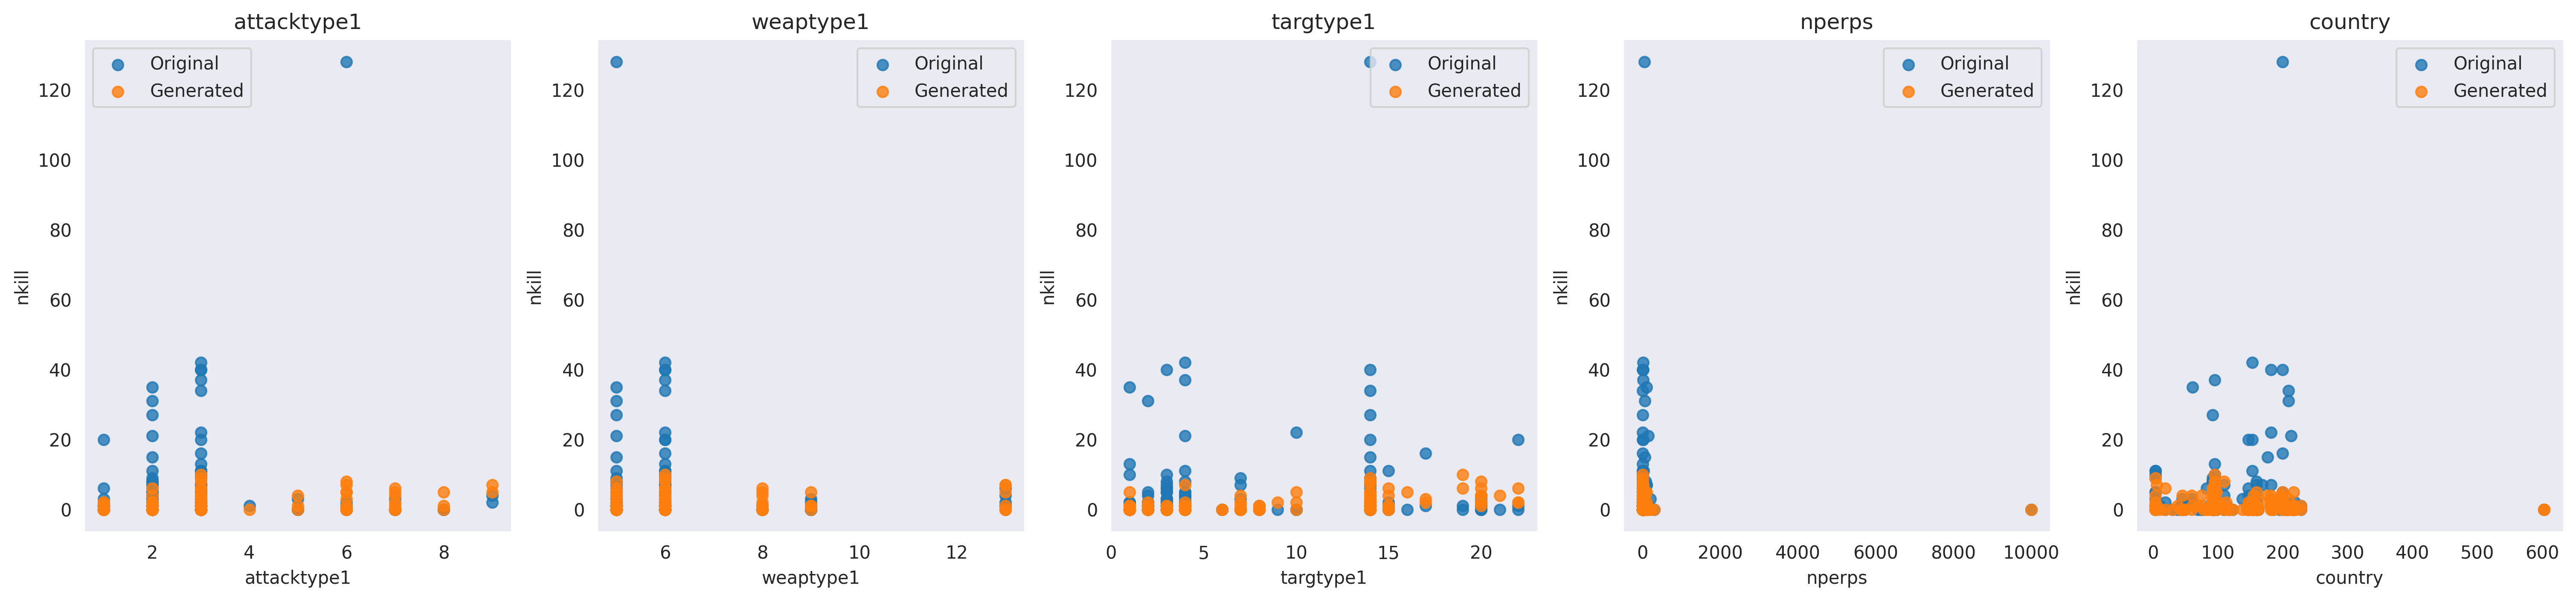

In [17]:
scatter_compare_display(X, df["nkill"], df_2_ppc.iloc[0][17:])

The generated samples from the prior make sense and align with the initial assumptions.

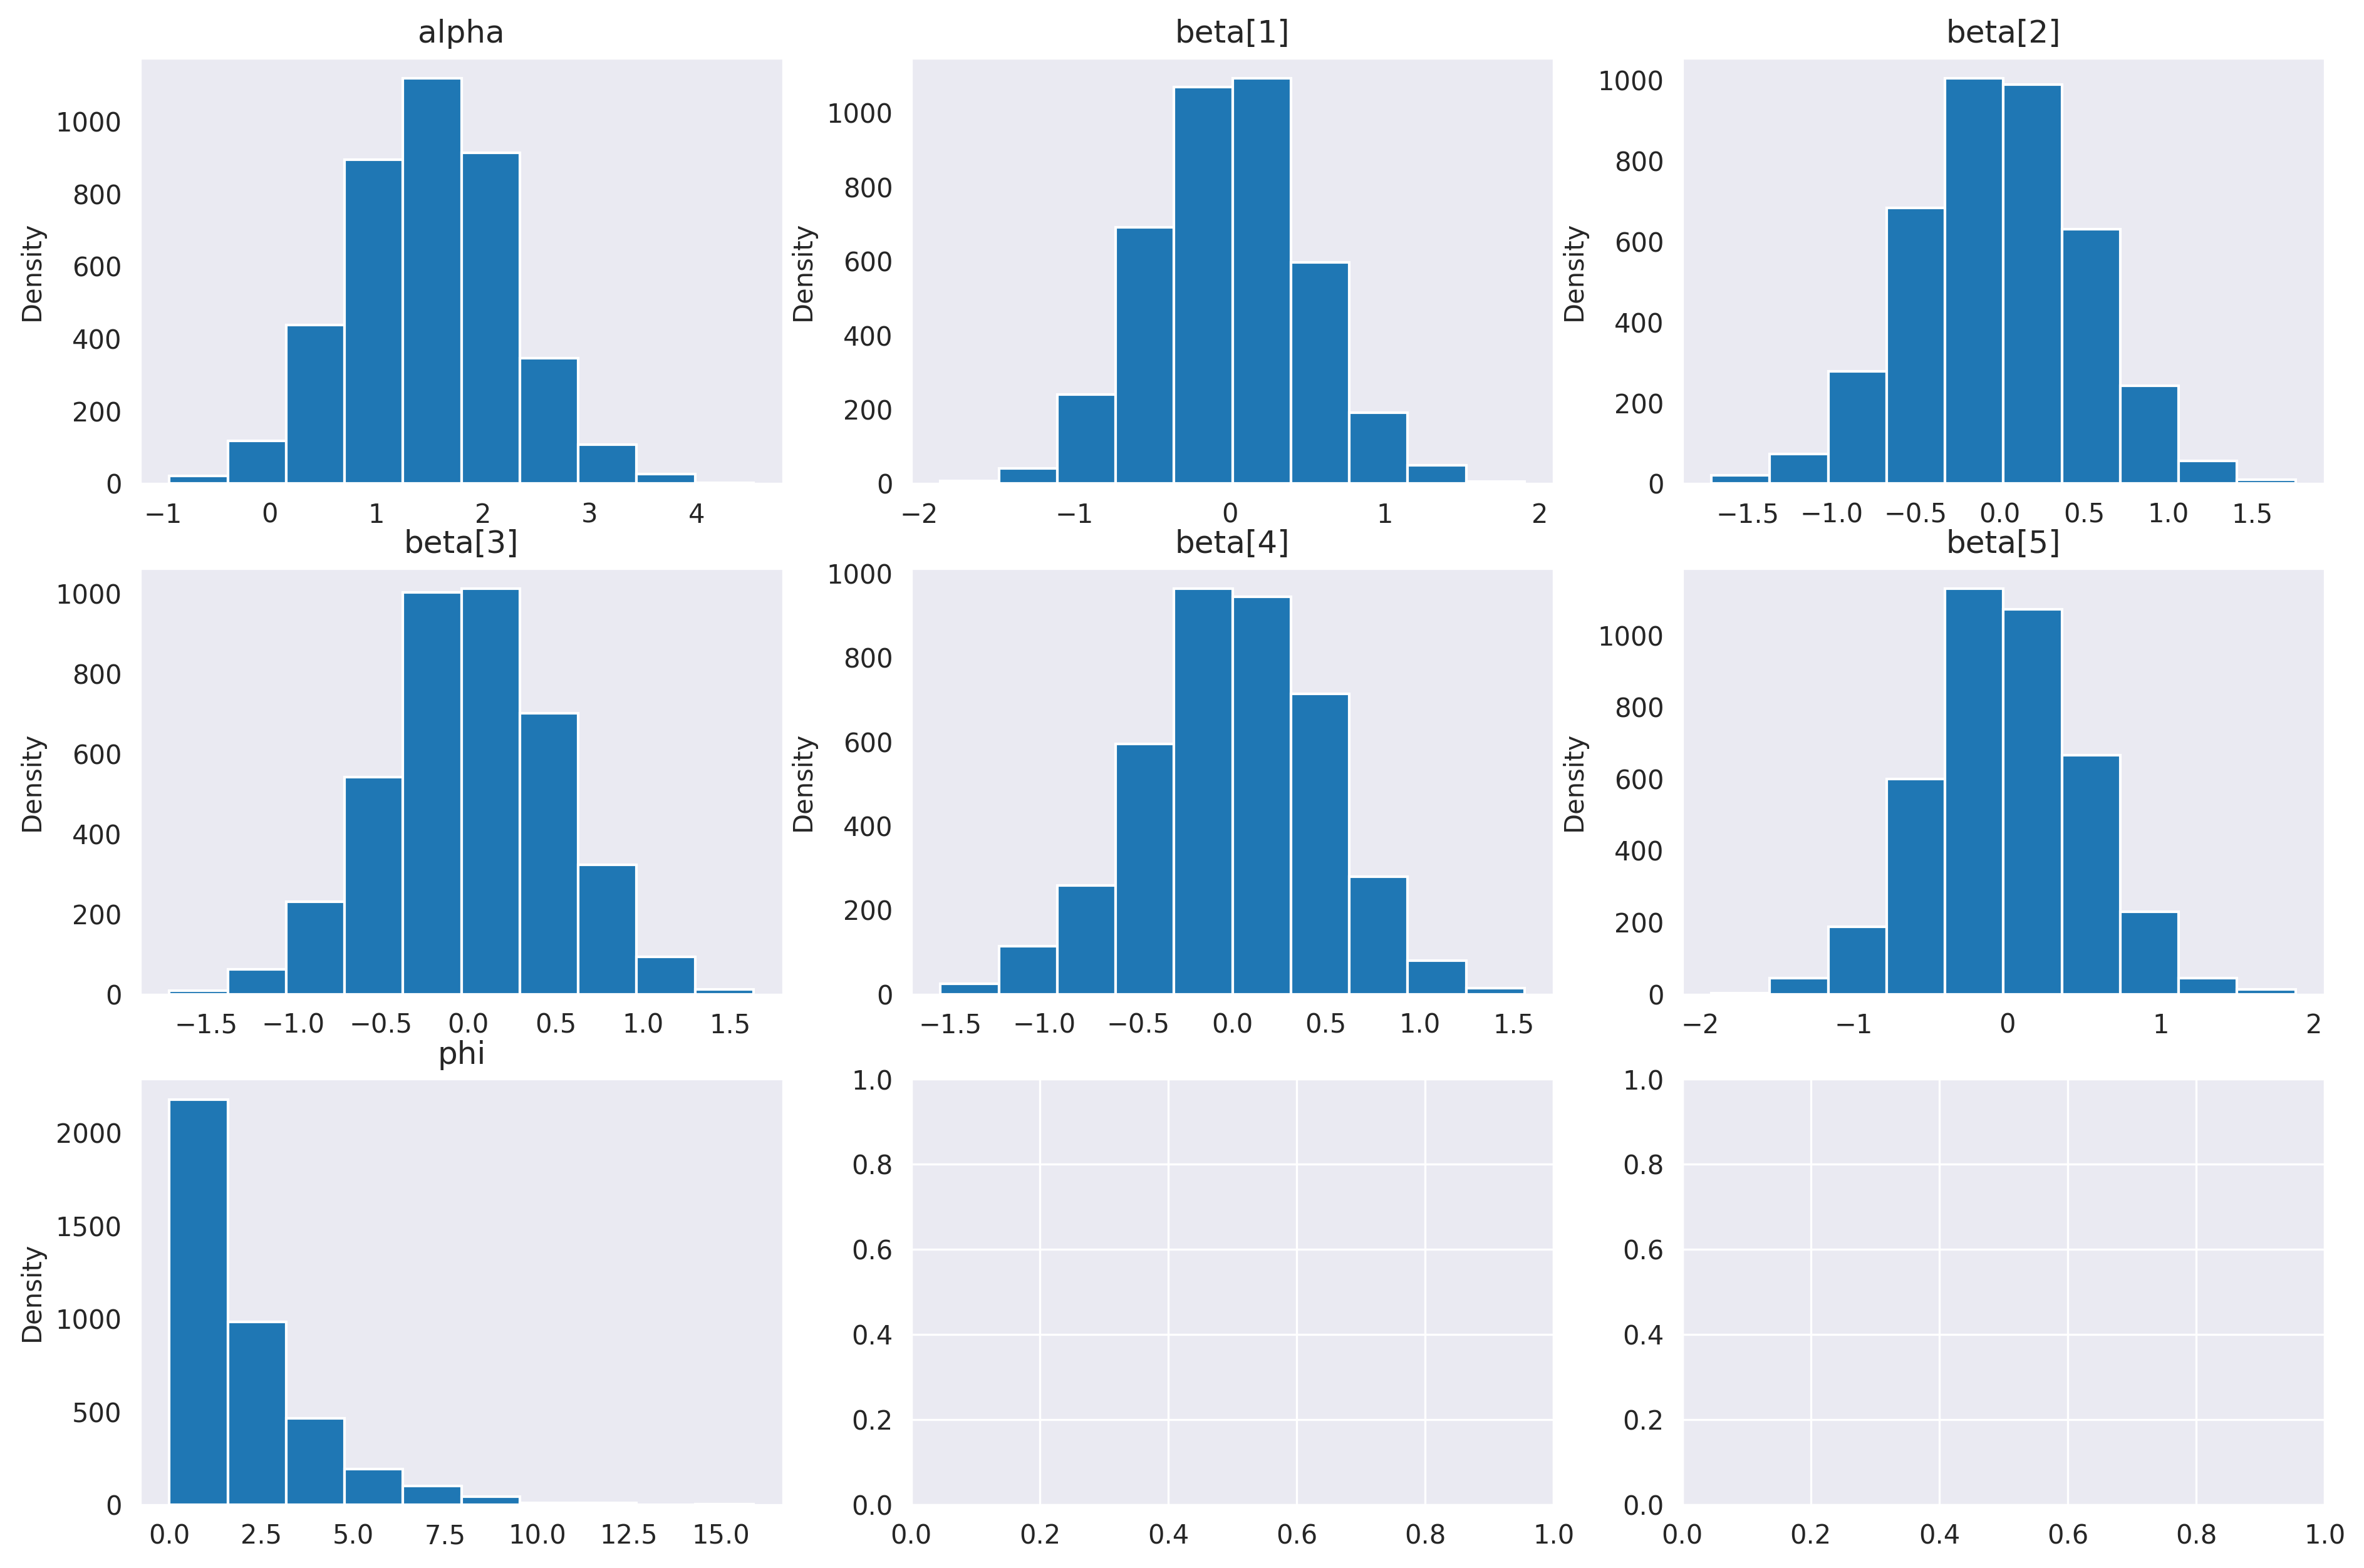

In [18]:
fig, axs = plt.subplots(3, 3, dpi=300)
fig.set_size_inches(15, 10)

for i, col in enumerate(["alpha", 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]', 'phi']):
    axs[i//3, i%3].hist(df_2_ppc[col])
    axs[i//3, i%3].set_ylabel("Density")
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].grid()

Histograms also confirm, that the prior distribution comply with the initial assumptions.

### 5. Posterior analysis

#### Model 1

In [19]:
model1_prod = CmdStanModel(stan_file=MODEL_PATH_1)

sim1_prod = model1_prod.sample(data=data_sim_prod,
                                seed=123)

df_1_prod = sim1_prod.draws_pd()

18:54:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:54 - cmdstanpy - INFO - CmdStan done processing.


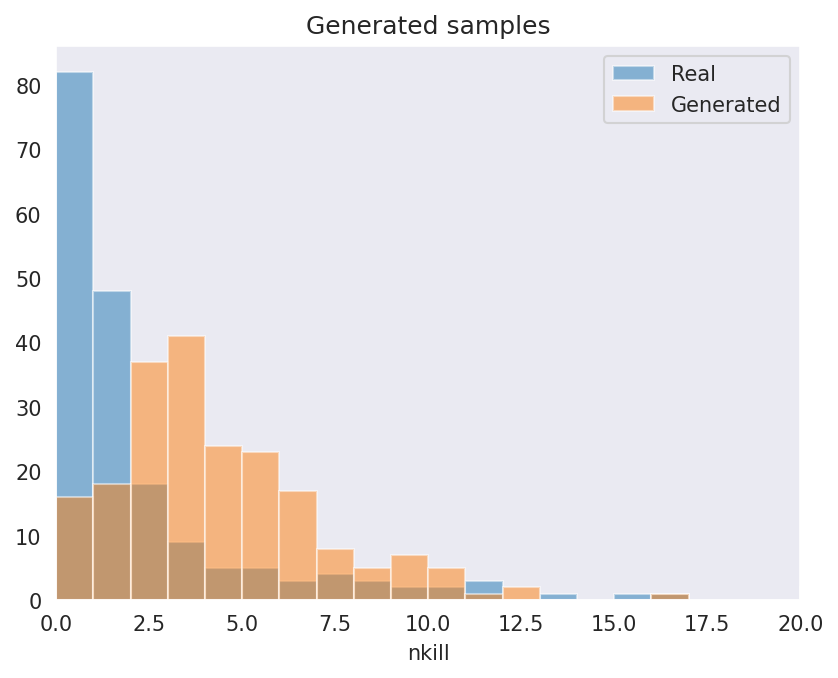

In [20]:
hist_compare(df['nkill'], df_1_prod.iloc[0][8:])

In [21]:
for n in range(0, 100):
    true_count = np.sum(df['nkill'] == n)
    pred_count = np.sum(np.round(df_1_prod.iloc[0][8:]) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")

Number of victims = 0: Real = 82, Predicted = 18
Number of victims = 1: Real = 48, Predicted = 18
Number of victims = 2: Real = 18, Predicted = 37
Number of victims = 3: Real = 9, Predicted = 41
Number of victims = 4: Real = 5, Predicted = 24
Number of victims = 5: Real = 5, Predicted = 23
Number of victims = 6: Real = 3, Predicted = 17
Number of victims = 7: Real = 4, Predicted = 8
Number of victims = 8: Real = 3, Predicted = 5
Number of victims = 9: Real = 2, Predicted = 7
Number of victims = 10: Real = 2, Predicted = 5
Number of victims = 11: Real = 3, Predicted = 1
Number of victims = 12: Real = 0, Predicted = 2
Number of victims = 13: Real = 1, Predicted = 0
Number of victims = 15: Real = 1, Predicted = 0
Number of victims = 16: Real = 1, Predicted = 1
Number of victims = 20: Real = 2, Predicted = 0
Number of victims = 21: Real = 1, Predicted = 0
Number of victims = 22: Real = 1, Predicted = 0
Number of victims = 27: Real = 1, Predicted = 0
Number of victims = 31: Real = 1, Predic

Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200


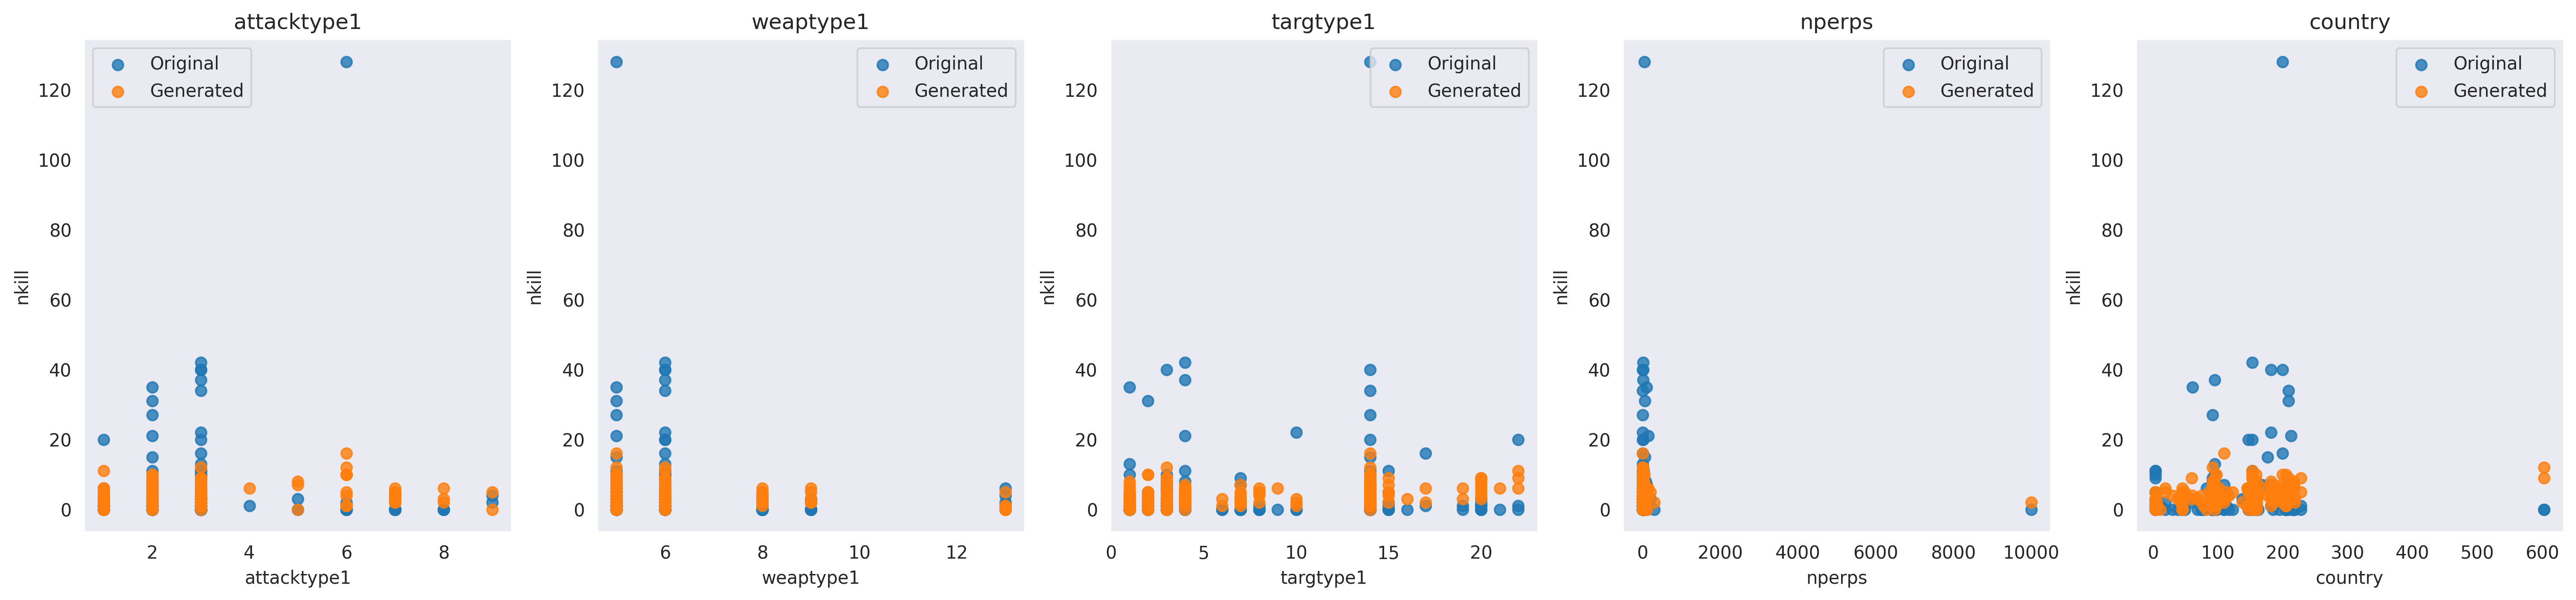

In [22]:
scatter_compare_display(X, df["nkill"], df_1_prod.iloc[0][16:])

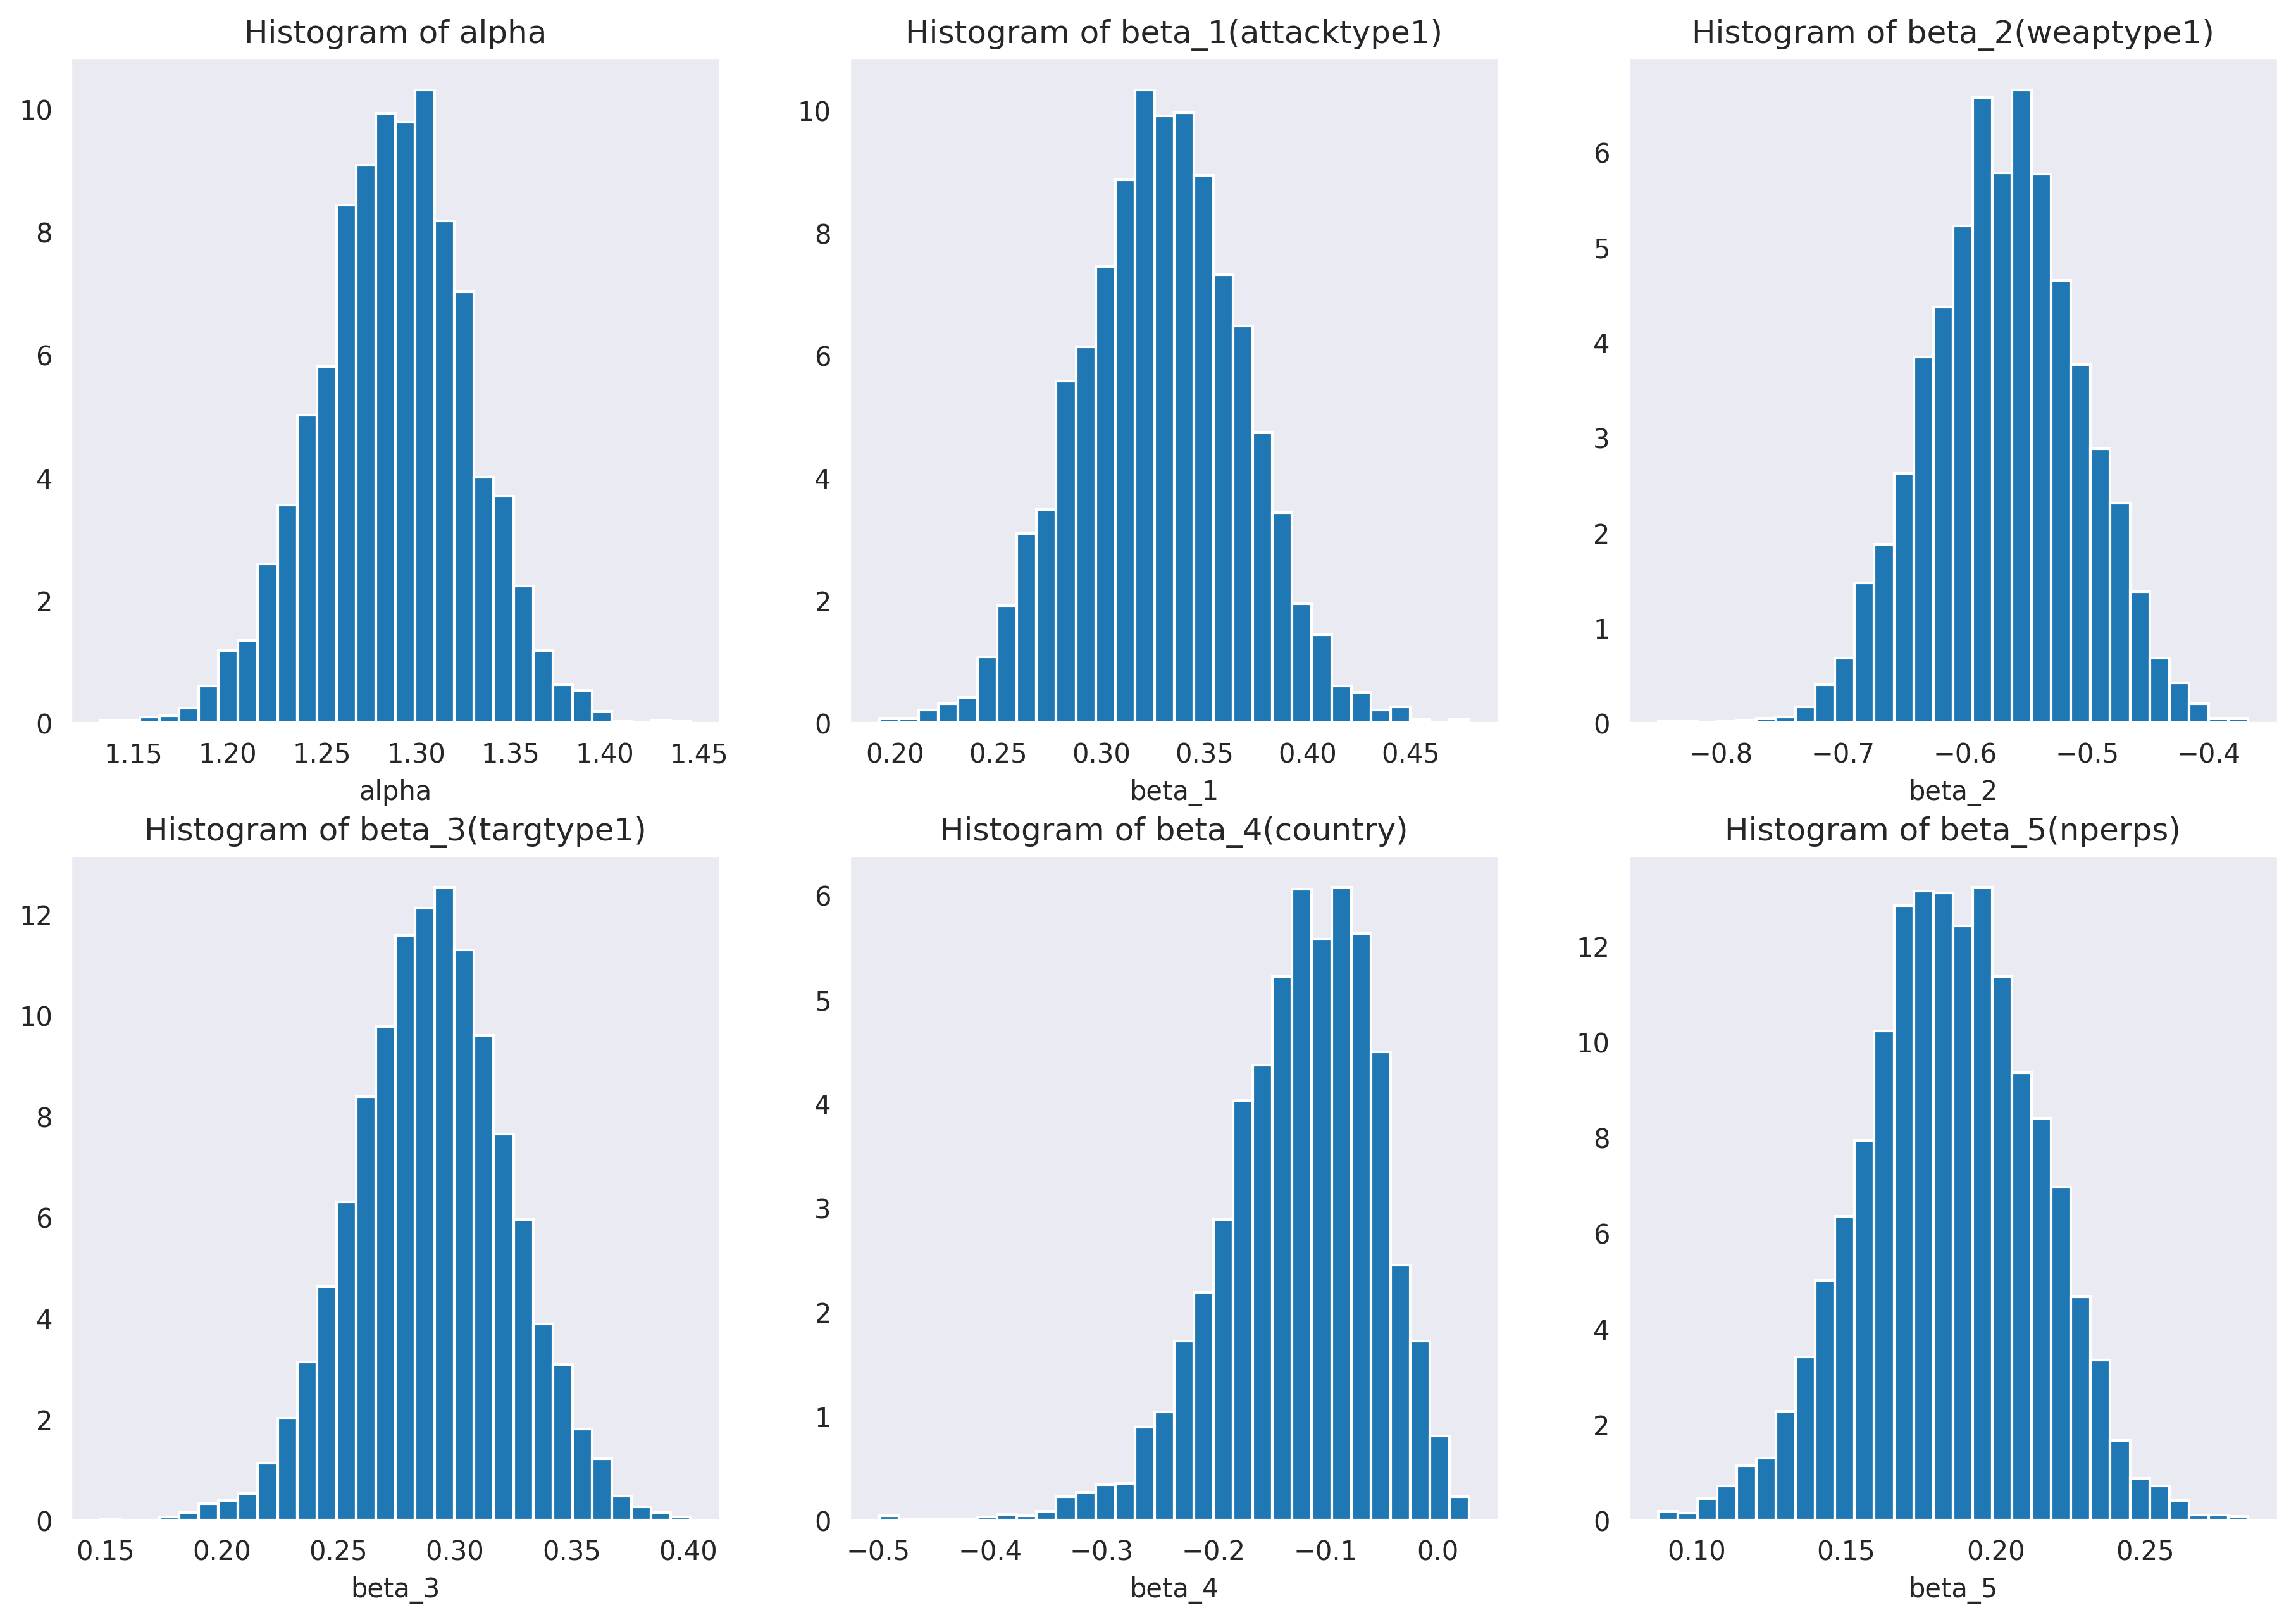

In [23]:
alpha = sim1_prod.stan_variable('alpha')
beta = sim1_prod.stan_variable('beta')

# plt.figure(dpi=300)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300)

axes[0, 0].hist(alpha, bins=30, density=True)
axes[0, 0].set_title(f'Histogram of alpha')
axes[0, 0].set_xlabel(f'alpha')
axes[0, 0].grid()

for i, el in enumerate(['attacktype1', 'weaptype1', 'targtype1', 'country', 'nperps']):
    axes[(i+1)//3, (i+1)%3].hist(beta[:, i], bins=30, density=True)
    axes[(i+1)//3, (i+1)%3].set_title(f'Histogram of beta_{i+1}({el})')
    axes[(i+1)//3, (i+1)%3].set_xlabel(f'beta_{i+1}')
    axes[(i+1)//3, (i+1)%3].grid()


plt.show()

#### Model 2


In [24]:
model1_prod = CmdStanModel(stan_file=MODEL_PATH_2)

sim2_prod = model1_prod.sample(data=data_sim_prod,
                                seed=123)

df_2_prod = sim2_prod.draws_pd()

18:54:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:57 - cmdstanpy - INFO - CmdStan done processing.
18:54:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Consider re-running with show_console=True if the above output is unclear!


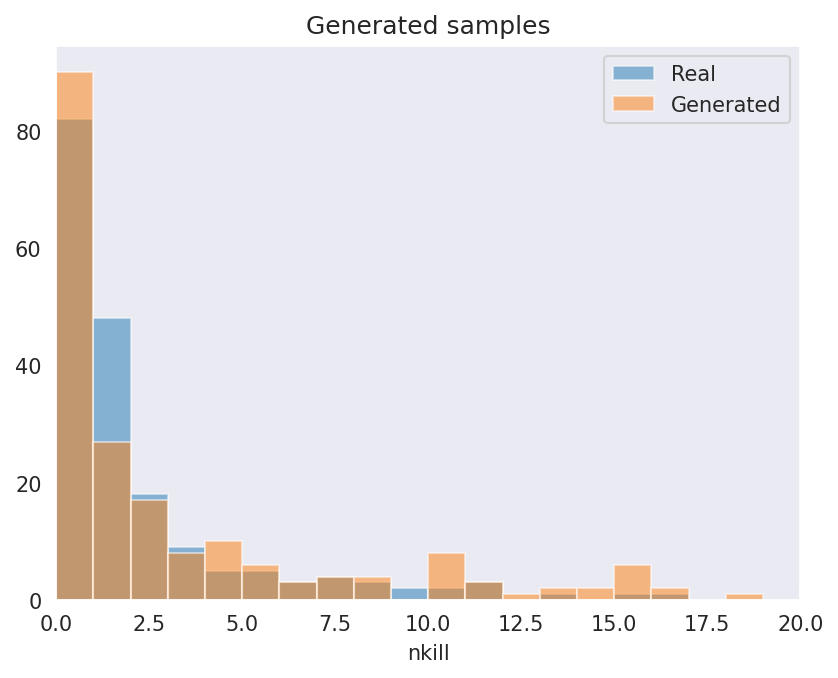

In [25]:
hist_compare(df['nkill'], df_2_prod.iloc[0][8:])

From the histogram, it can be concluded that the posterior model is able to describe the observed data.
The model seems to be valid, however some samples are overestimated and some are underestimated.
The model have one constrain, the Phi parameter must be non-negative.
What is more, the model can overestimate extreme values, as we can see, model generated more cases above 10 victims.

It is important to note that the data generated by model is more dispersed.
This could lead to that model provides more high, rare data, than happened in real world.

TODO add comparison to first model note.

Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200
Length x (val_mat[col]): 200
Length y (y_values_gen): 200


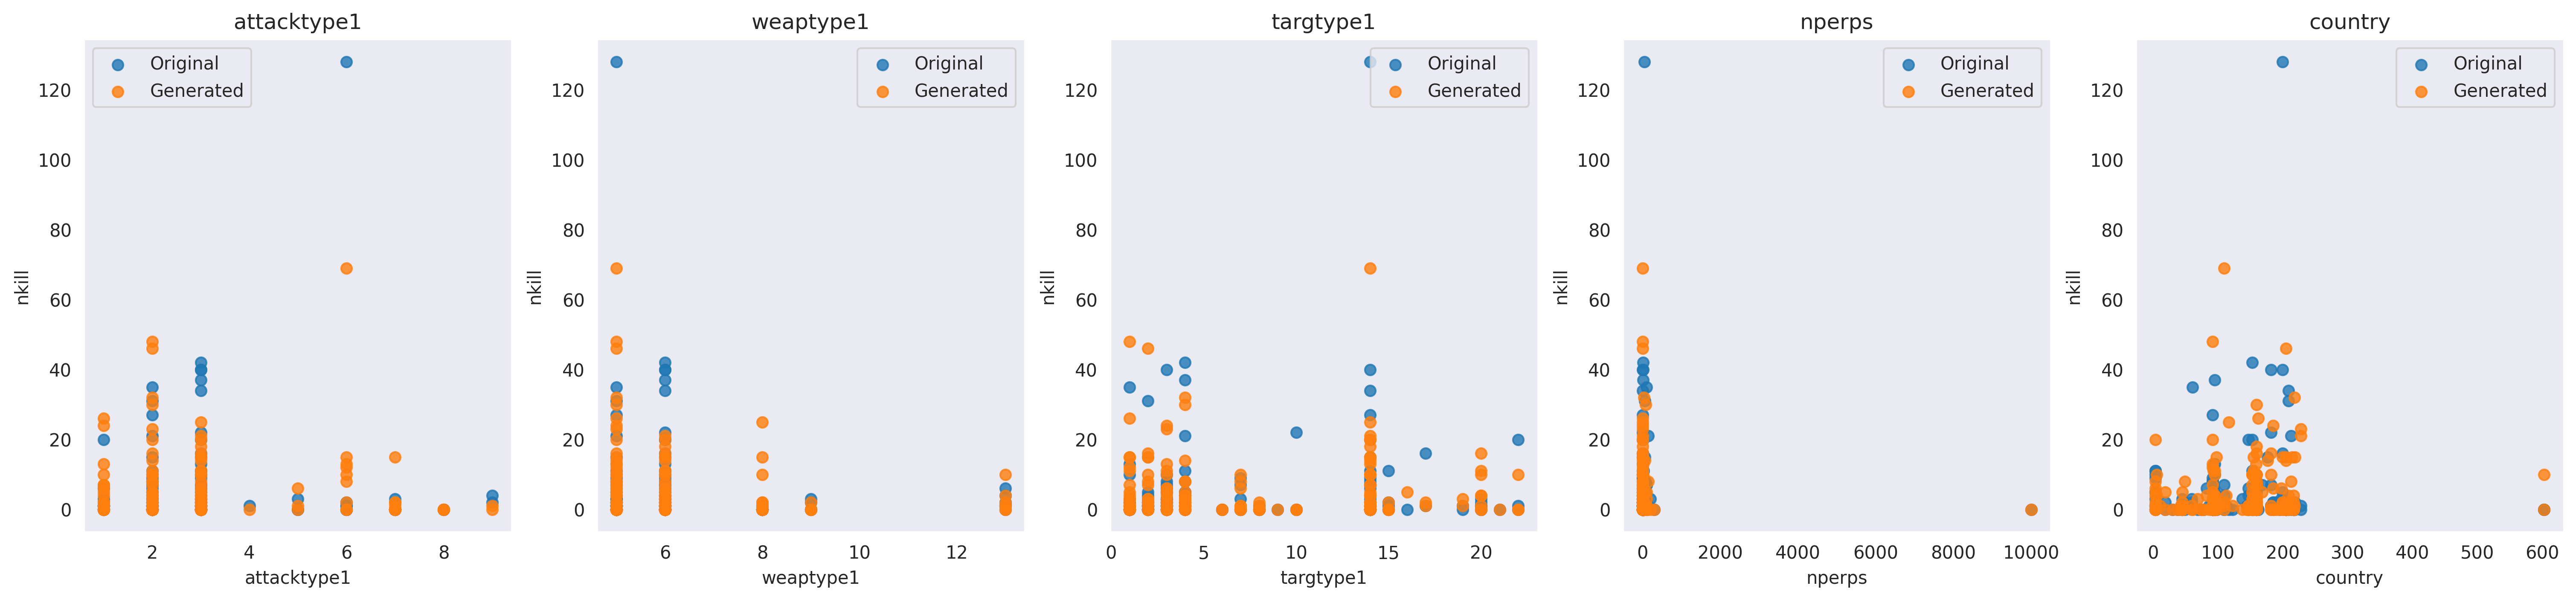

In [26]:
scatter_compare_display(X, df["nkill"], df_2_prod.iloc[0][17:])

From the scatter plots, we can observe the model can generate valid data, which matches with the real one.
This suggests that the posterior model has learned from the data and is able to generate samples that can capture variability in the real data.

alpha shape: (4000,)
beta shape: (4000, 5)
[[ 0.0985926  -0.278027    0.0184197  -0.224862    0.0431184 ]
 [ 0.188811   -0.0324176   0.446953   -0.497603    0.307154  ]
 [ 0.00564068 -0.331904    0.0229874   0.308413   -0.0838599 ]
 ...
 [ 0.134612   -0.296009    0.214218   -0.471042    0.364583  ]
 [-0.0318048  -0.227652    0.202501   -0.141224    0.247042  ]
 [ 0.226267   -0.130306    0.334241   -0.184833    0.200542  ]]


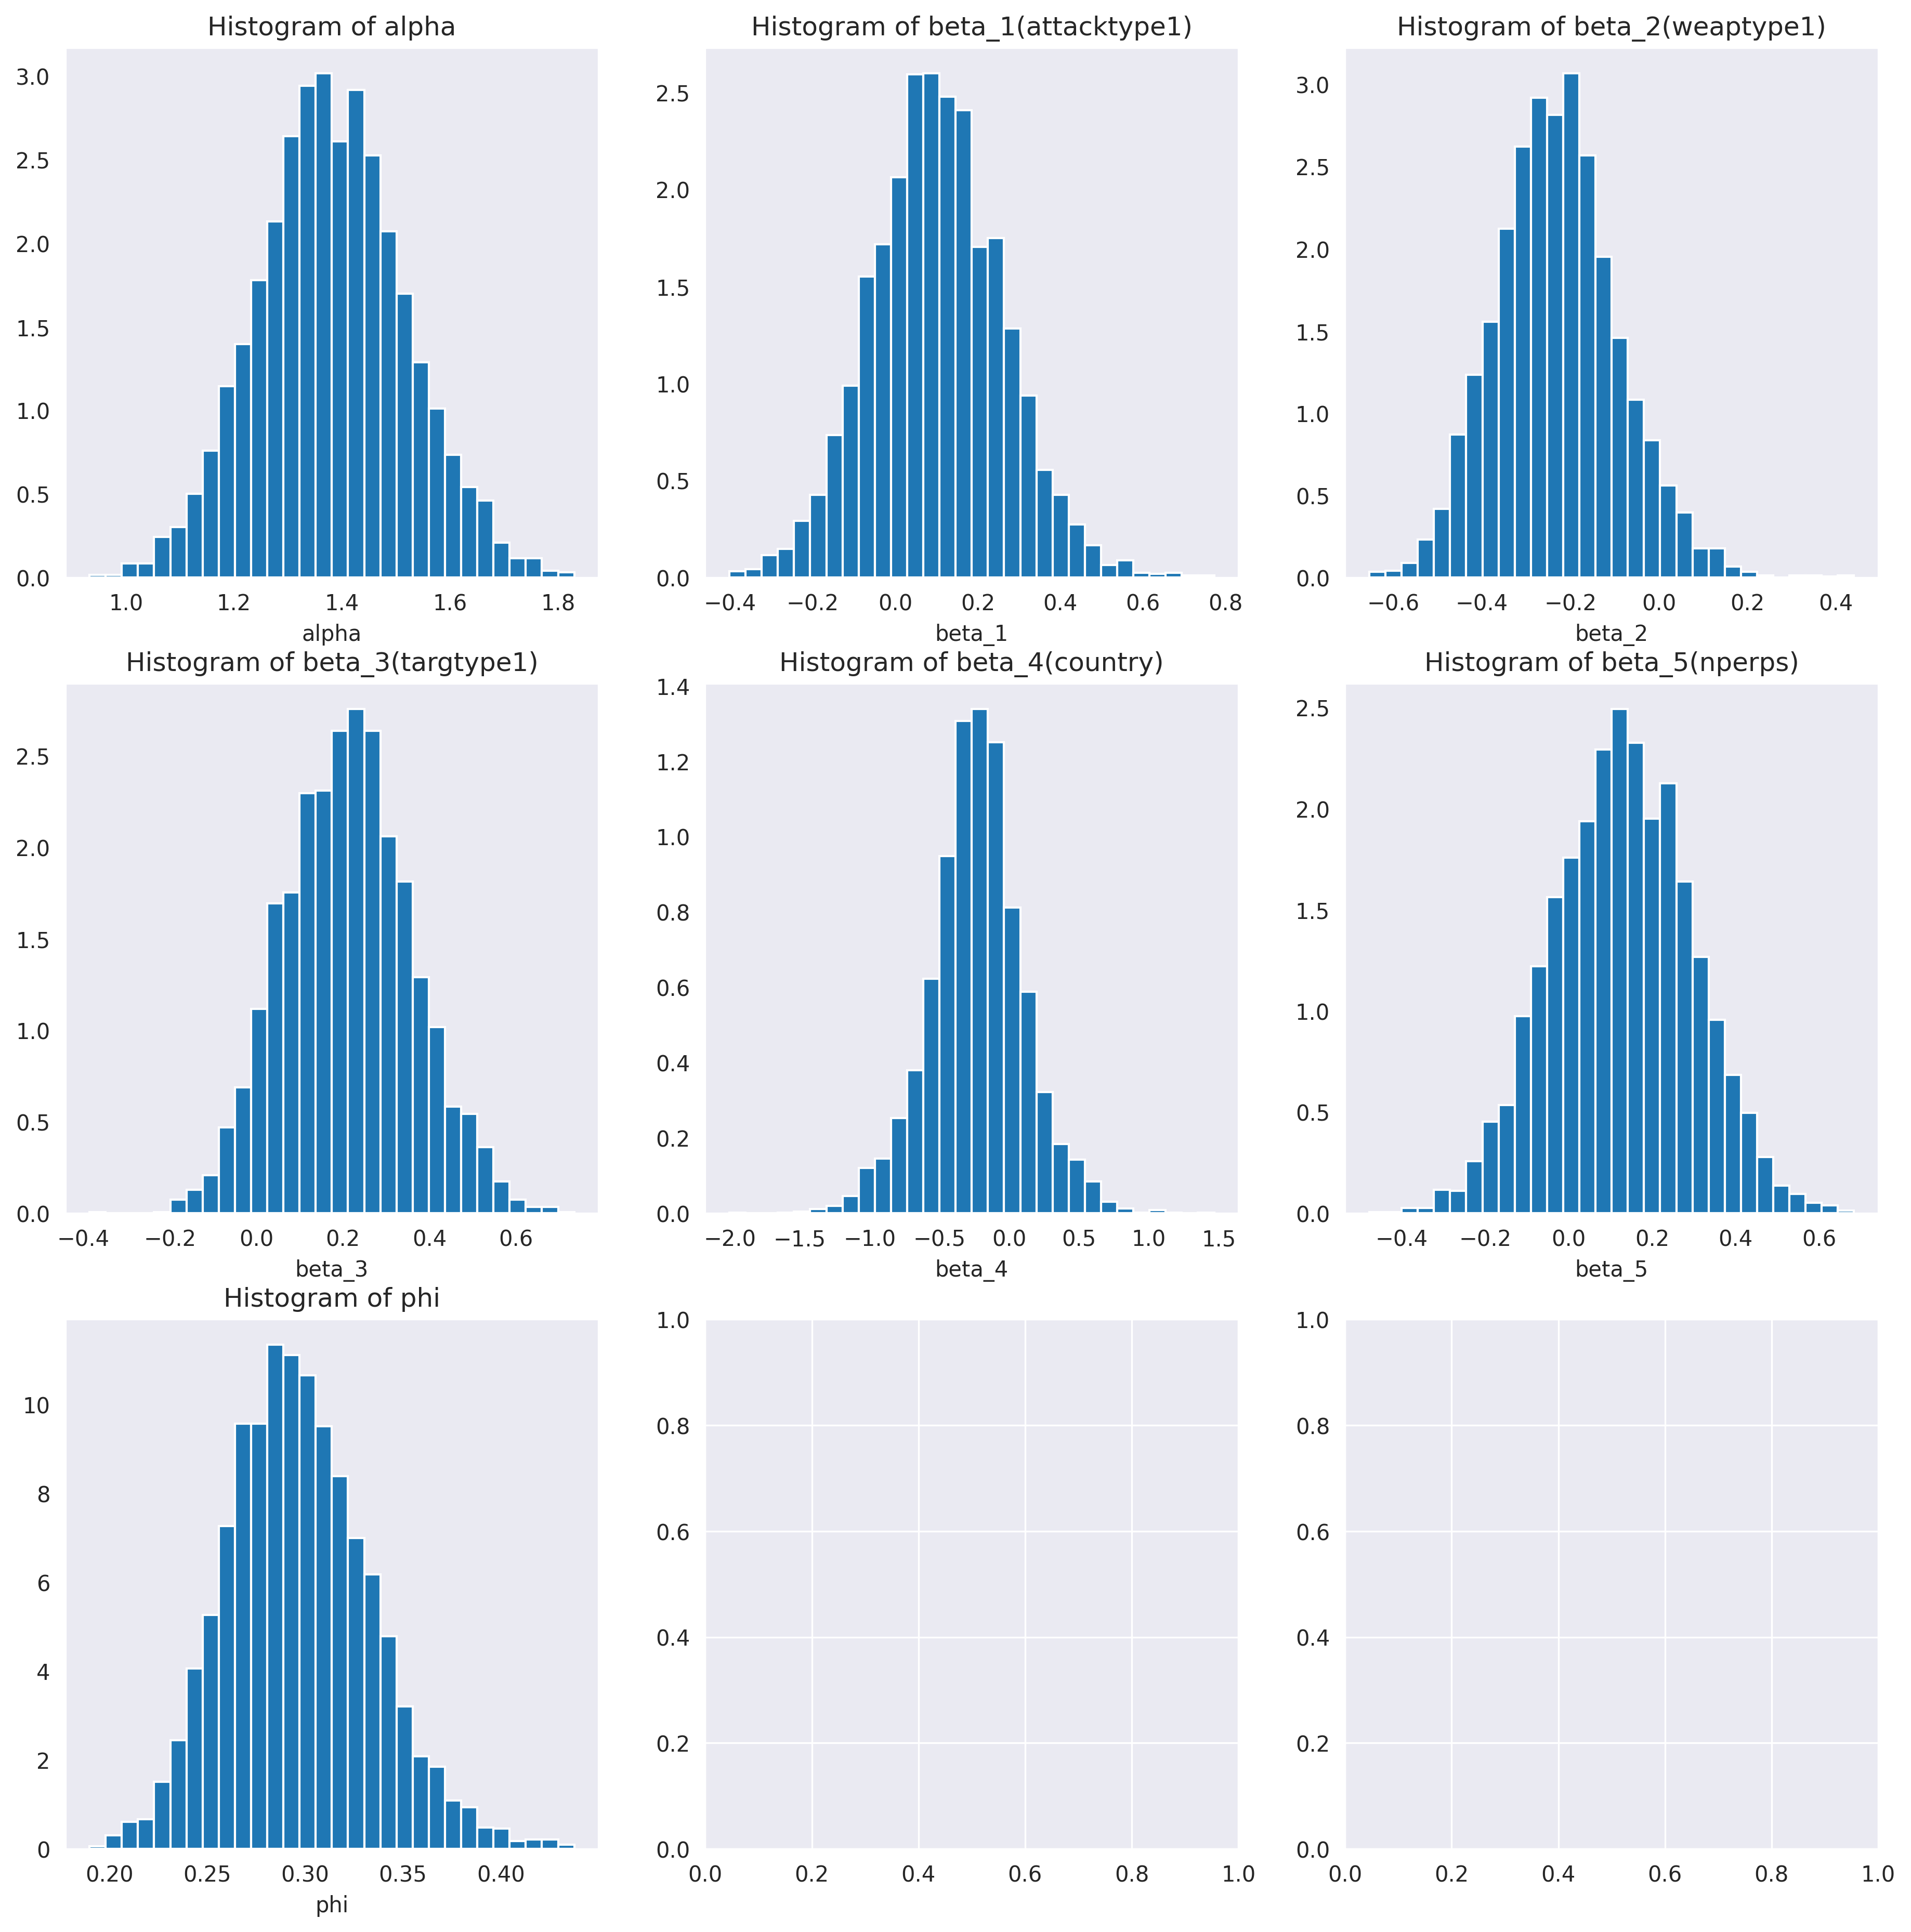

In [27]:
alpha = sim2_prod.stan_variable('alpha')
beta = sim2_prod.stan_variable('beta')
phi = sim2_prod.stan_variable('phi')
print("alpha shape:", alpha.shape)
print("beta shape:", beta.shape)
print(beta)

# plt.figure(dpi=300)
fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=300)

axes[0, 0].hist(alpha, bins=30, density=True)
axes[0, 0].set_title(f'Histogram of alpha')
axes[0, 0].set_xlabel(f'alpha')
axes[0, 0].grid()

for i, el in enumerate(['attacktype1', 'weaptype1', 'targtype1', 'country', 'nperps']):
    axes[(i+1)//3, (i+1)%3].hist(beta[:, i], bins=30, density=True)
    axes[(i+1)//3, (i+1)%3].set_title(f'Histogram of beta_{i+1}({el})')
    axes[(i+1)//3, (i+1)%3].set_xlabel(f'beta_{i+1}')
    axes[(i+1)//3, (i+1)%3].grid()

axes[2, 0].hist(phi, bins=30, density=True)
axes[2, 0].set_title(f'Histogram of phi')
axes[2, 0].set_xlabel(f'phi')
axes[2, 0].grid()


plt.show()

The histograms created from generated samples, which are presented above, confirm that the posterior distributions comply with the initial assumptions.

### 6. Model comparison

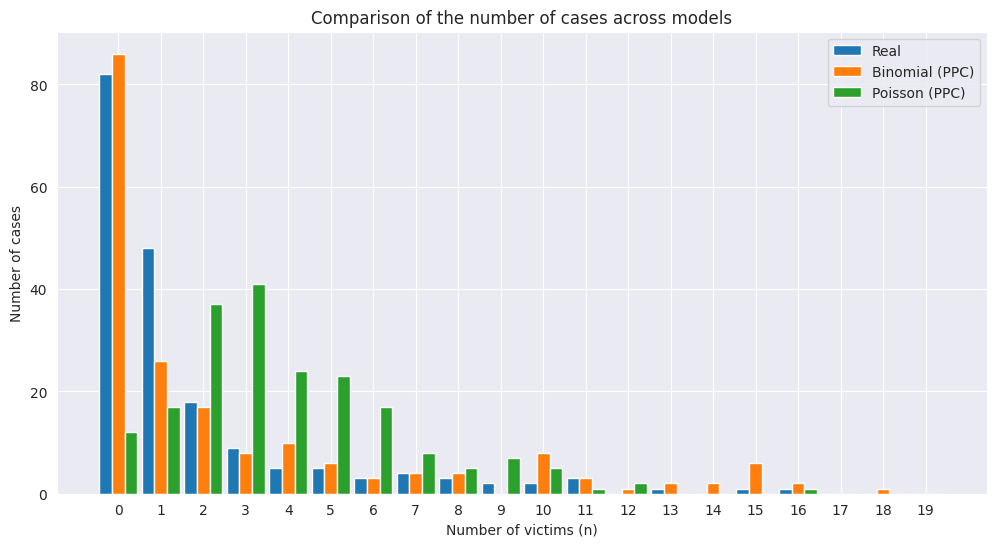

In [28]:
n_values = np.arange(0, 20)

true_counts = []
binomial_counts = []
poisson_counts = []

for n in n_values:
    true_count = np.sum(df["nkill"].values == n)
    binomial_count = np.sum(np.round(df_2_prod.iloc[0][16:]) == n)
    poisson_count = np.sum(np.round(df_1_prod.iloc[0][16:]) == n)
    
    true_counts.append(true_count)
    binomial_counts.append(binomial_count)
    poisson_counts.append(poisson_count)


bar_width = 0.3
index = np.arange(len(n_values))

plt.figure(figsize=(12,6))
plt.bar(index - bar_width, true_counts, bar_width, label='Real')
plt.bar(index, binomial_counts, bar_width, label='Binomial (PPC)')
plt.bar(index + bar_width, poisson_counts, bar_width, label='Poisson (PPC)')

plt.xlabel('Number of victims (n)')
plt.ylabel('Number of cases')
plt.xticks(index, n_values)
plt.legend()
plt.title('Comparison of the number of cases across models')
plt.show()

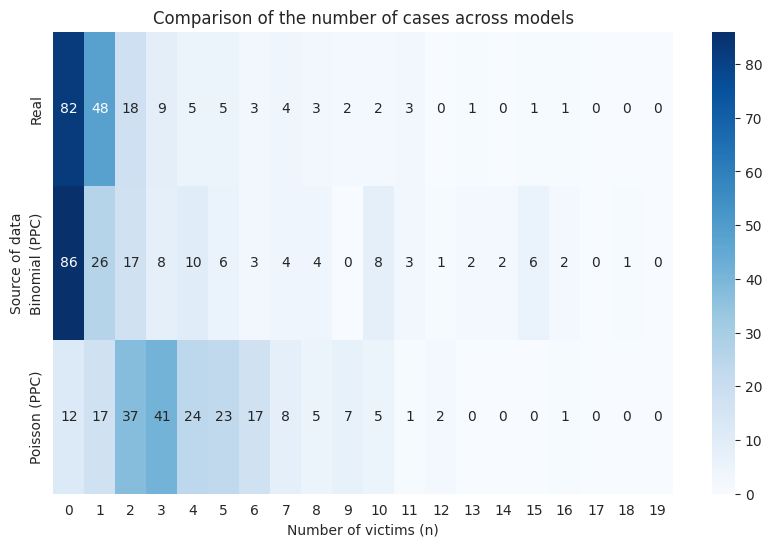

In [29]:
df_heatmap = pd.DataFrame({
    'n': n_values,
    'Real': true_counts,
    'Binomial (PPC)': binomial_counts,
    'Poisson (PPC)': poisson_counts
}).set_index('n')

plt.figure(figsize=(10,6))
sns.heatmap(df_heatmap.T, annot=True, fmt='d', cmap='Blues')
plt.title('Comparison of the number of cases across models')
plt.xlabel('Number of victims (n)')
plt.ylabel('Source of data')
plt.show()

#### LOO Compare

In [30]:
model1_prod_info = az.from_cmdstanpy(posterior=sim1_prod)
model2_prod_info = az.from_cmdstanpy(posterior=sim2_prod)

log_lik_1 = compute_poisson_log_likelihood(model1_prod_info, X, df['nkill'])
log_lik_2 = compute_negbinom_log_likelihood(model2_prod_info, X, df['nkill'])

n_chains_1 = model1_prod_info.posterior.sizes['chain']
n_draws_1 = model1_prod_info.posterior.sizes['draw']
n_chains_2 = model2_prod_info.posterior.sizes['chain']
n_draws_2 = model2_prod_info.posterior.sizes['draw']

# Reshape log-likelihood arrays
log_lik_1_reshaped = log_lik_1.reshape(n_chains_1, n_draws_1, -1)
log_lik_2_reshaped = log_lik_2.reshape(n_chains_2, n_draws_2, -1)

log_lik_da_1 = xr.DataArray(
    log_lik_1_reshaped,
    dims=['chain', 'draw', 'nkill_dim_0'],
    coords={
        'chain': model1_prod_info.posterior.chain,
        'draw': model1_prod_info.posterior.draw,
        'nkill_dim_0': range(len(df['nkill']))
    }
)

log_lik_da_2 = xr.DataArray(
    log_lik_2_reshaped,
    dims=['chain', 'draw', 'nkill_dim_0'],
    coords={
        'chain': model2_prod_info.posterior.chain,
        'draw': model2_prod_info.posterior.draw,
        'nkill_dim_0': range(len(df['nkill']))
    }
)

model1_with_ll = az.InferenceData(
    posterior=model1_prod_info.posterior,
    log_likelihood=xr.Dataset({'nkill': log_lik_da_1}),
    **{group: getattr(model1_prod_info, group)
       for group in model1_prod_info._groups_all
       if group not in ['posterior']}
)

model2_with_ll = az.InferenceData(
    posterior=model2_prod_info.posterior,
    log_likelihood=xr.Dataset({'nkill': log_lik_da_2}),
    **{group: getattr(model2_prod_info, group)
       for group in model2_prod_info._groups_all
       if group not in ['posterior']}
)


models_dict = {
    "model1": model1_with_ll,
    "model2": model2_with_ll
}

loo_comparison = az.compare(models_dict, ic="loo", scale="negative_log")
display(loo_comparison)

/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:978: RuntimeWarning: invalid value encountered in subtract
  x -= np.max(x)
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1,0,1.122560e+131,1.122560e+131,0.0,0.5,1.119750e+131,0.0,True,negative_log
model2,1,NaN,NaN,NaN,0.5,NaN,NaN,True,negative_log


TODO add note

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (-log)', ylabel='ranked models'>

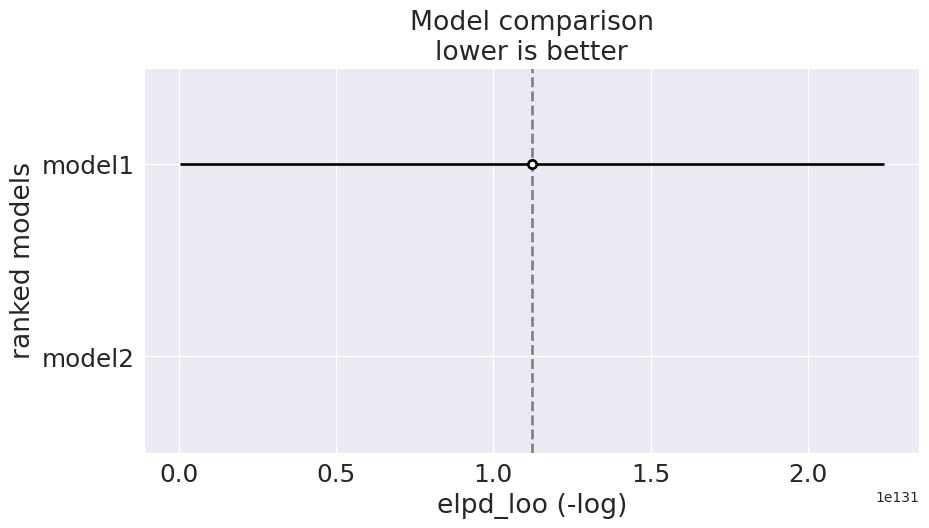

In [31]:
az.plot_compare(loo_comparison, figsize=(10, 5))

#### WAIC Compare

In [34]:
waic_comparison = az.compare(models_dict, ic="waic", scale="negative_log")
display(waic_comparison)

/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1867: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:237: RuntimeWarn

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model1,0,3.149565e+258,3.149565e+258,0.0,0.5,inf,0.0,True,negative_log
model2,1,NaN,NaN,NaN,0.5,NaN,NaN,True,negative_log


TODO add note

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (-log)', ylabel='ranked models'>

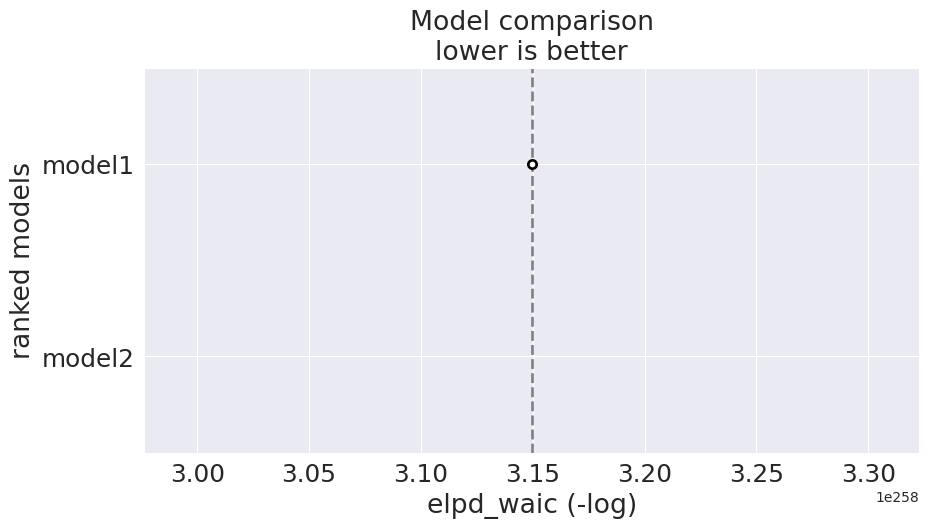

In [35]:
az.plot_compare(waic_comparison, figsize=(10, 5))